# Score weak estimators
## Import libraries

In [1]:
import pandas as pd
import re
from pathlib import Path
from constants import PROJECT_PATH, TOKENIZER_SUFFIXES
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from constants import PLOT_PATH
import matplotlib

colours = reversed(['#56B4E9', '#0072B2', '#E69F00', '#D55E00'])
#colours = reversed(['#332288', '#117733', '#44AA99', '#88CCEE', '#7bafde', '#1965B0', '#AA4499', '#882255'])
matplotlib.rcParams['axes.prop_cycle'] = cycler('color', colours)

/home/jgut/miniconda3/envs/SMILES_OR_SELFIES/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/jgut/miniconda3/envs/SMILES_OR_SELFIES/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


## Define useful classes

In [2]:
import ast
import json
import re
from statistics import mean, stdev

def clean_string(string:str):
    string = re.sub(r"\'param\_.*\)\,\'params\'", "'params'",string)
    string = string.replace("array([", "[").replace("])", "]")
    string = re.sub(r"\],\s*dtype=.*\),", "],",string)
    return string

def reading_dict(path:Path):
    with open(path, 'r') as f:
        lines = f.readlines()
    #skip first line with estimator name
    return lines[0].strip(), ast.literal_eval(clean_string("".join([line.strip() for line in lines[1:]])))

def get_cells(line:str)->[str]:
    return [cell.strip() for cell in re.split("  ", line) if len(cell)>0]

def parse_dict(dikt:dict):
    best_model_index = dikt['rank_test_score'].index(1)
    best_params = dikt["params"][best_model_index]
    best_scores = []
    for i in range(3):
        best_scores.append(abs(float(dikt[f"split{i}_test_score"][best_model_index])))
    return best_params, mean(best_scores), stdev(best_scores)

def get_report(path:Path):
    estimator, dikt = reading_dict(path)
    best_params, mean_best_scores, std_best_scores = parse_dict(dikt)
    return {"estimator": estimator, "best_params":best_params, "best_scores": mean_best_scores, "std": std_best_scores,}

def parse_tokenizer(tokenizer_string:str):
    """Parse tokenizer string

    Args:
        tokenizer_string (str): tokenizer string to parse

    Returns:
        Dict[str, str]: dictionary with tokenizer settings
    """
    tokenizer_parts = tokenizer_string.split("_")
    output = {
        "embedding": tokenizer_parts[0],
        "tokenizer": tokenizer_parts[1],
        "dataset": tokenizer_parts[2],
    }
    return output
interesting_rows = [['selfies', 'atom','standard','roberta'],['smiles', 'atom','standard','roberta'], ['selfies','atom','standard','bart'], ['smiles', 'atom','standard','bart'],]

## Compute dataframe

In [3]:
entries = []
for descriptor_name in ["Chi0v","Heterocycles", "NumHDonors","Kappa1", "MolLogP", "MolMR", "QED"]:
    for tokenizer_suffix in TOKENIZER_SUFFIXES:
        for model in ["bart", "roberta"]:
            report_parent_path = PROJECT_PATH / f"embeddings_{model}" / descriptor_name / tokenizer_suffix / "reports"
            if not report_parent_path.exists():
                continue
            for estimators_file in report_parent_path.glob("*.txt"):
                entry = {"descriptor": descriptor_name, "architecture": model} | parse_tokenizer(tokenizer_suffix) | get_report(estimators_file) 
                entries.append(entry)
df = pd.DataFrame(entries)
df

,descriptor,architecture,embedding,tokenizer,dataset,estimator,best_params,best_scores,std
0,Chi0v,bart,smiles,atom,isomers,Linear SVR,{'C': 10},2.763345,0.165463
1,Chi0v,bart,smiles,atom,isomers,RBF SVR,{'C': 10},1.959920,0.195276
2,Chi0v,bart,smiles,atom,isomers,KNN,"{'n_neighbors': 5, 'weights': 'distance'}",2.766800,0.046068
3,Chi0v,roberta,smiles,atom,isomers,Linear SVR,{'C': 10},2.628754,0.238604
4,Chi0v,roberta,smiles,atom,isomers,RBF SVR,{'C': 10},2.006648,0.310093
...,...,...,...,...,...,...,...,...,...
331,QED,bart,selfies,trained,standard,RBF SVR,{'C': 1},0.113933,0.000147
332,QED,bart,selfies,trained,standard,KNN,"{'n_neighbors': 11, 'weights': 'distance'}",0.150011,0.001892
333,QED,roberta,selfies,trained,standard,Linear SVR,{'C': 0.1},0.130800,0.004075
334,QED,roberta,selfies,trained,standard,RBF SVR,{'C': 10},0.106637,0.000250


## Diced by estimator

In [4]:
for estimator in df.estimator.unique():
    for descriptor in df.descriptor.unique(): 
        print(f"Estimator {estimator}, descriptor {descriptor}")
        display(df[["descriptor","embedding","tokenizer","dataset","estimator", "best_scores","std","architecture"]][df.estimator==estimator][df.descriptor==descriptor].sort_values("best_scores"))
        print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))

Estimator Linear SVR, descriptor Chi0v


/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding","tokenizer","dataset","estimator", "best_scores","std","architecture"]][df.estimator==estimator][df.descriptor==descriptor].sort_values("best_scores"))


,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
33,Chi0v,selfies,atom,standard,Linear SVR,2.218300,0.253373,roberta
21,Chi0v,smiles,trained,standard,Linear SVR,2.445087,0.100536,roberta
6,Chi0v,smiles,atom,standard,Linear SVR,2.617720,0.194198,bart
3,Chi0v,smiles,atom,isomers,Linear SVR,2.628754,0.238604,roberta
9,Chi0v,smiles,atom,standard,Linear SVR,2.630922,0.200719,roberta
27,Chi0v,selfies,atom,isomers,Linear SVR,2.634034,0.181847,roberta
0,Chi0v,smiles,atom,isomers,Linear SVR,2.763345,0.165463,bart
24,Chi0v,selfies,atom,isomers,Linear SVR,2.802106,0.112073,bart
45,Chi0v,selfies,trained,standard,Linear SVR,2.847377,0.188664,roberta
30,Chi0v,selfies,atom,standard,Linear SVR,2.894233,0.255244,bart


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset &   estimator & architecture &  best\_scores &   std \\
\midrule
0  &      Chi0v &    smiles &      atom &   isomers &  Linear SVR &         bart &        2.763 & 0.165 \\
3  &      Chi0v &    smiles &      atom &   isomers &  Linear SVR &      roberta &        2.629 & 0.239 \\
6  &      Chi0v &    smiles &      atom &  standard &  Linear SVR &         bart &        2.618 & 0.194 \\
9  &      Chi0v &    smiles &      atom &  standard &  Linear SVR &      roberta &        2.631 & 0.201 \\
12 &      Chi0v &    smiles &   trained &   isomers &  Linear SVR &         bart &        3.365 & 0.176 \\
15 &      Chi0v &    smiles &   trained &   isomers &  Linear SVR &      roberta &        3.733 & 0.144 \\
18 &      Chi0v &    smiles &   trained &  standard &  Linear SVR &         bart &        3.323 & 0.184 \\
21 &      Chi0v &    smiles &   trained &  standard &  Linear SVR &      roberta &        2.445 & 

/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator Linear SVR, descriptor NumHDonors


/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator Linear SVR, descriptor Kappa1


/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
177,Kappa1,selfies,atom,standard,Linear SVR,3.250562,0.339774,roberta
165,Kappa1,smiles,trained,standard,Linear SVR,3.334220,0.171393,roberta
147,Kappa1,smiles,atom,isomers,Linear SVR,3.748380,0.277909,roberta
171,Kappa1,selfies,atom,isomers,Linear SVR,3.804264,0.262108,roberta
144,Kappa1,smiles,atom,isomers,Linear SVR,3.808398,0.283795,bart
153,Kappa1,smiles,atom,standard,Linear SVR,3.813225,0.370643,roberta
174,Kappa1,selfies,atom,standard,Linear SVR,3.944261,0.246412,bart
189,Kappa1,selfies,trained,standard,Linear SVR,4.030287,0.253172,roberta
168,Kappa1,selfies,atom,isomers,Linear SVR,4.037760,0.233672,bart
150,Kappa1,smiles,atom,standard,Linear SVR,4.140094,0.503569,bart


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset &   estimator & architecture &  best\_scores &   std \\
\midrule
144 &     Kappa1 &    smiles &      atom &   isomers &  Linear SVR &         bart &        3.808 & 0.284 \\
147 &     Kappa1 &    smiles &      atom &   isomers &  Linear SVR &      roberta &        3.748 & 0.278 \\
150 &     Kappa1 &    smiles &      atom &  standard &  Linear SVR &         bart &        4.140 & 0.504 \\
153 &     Kappa1 &    smiles &      atom &  standard &  Linear SVR &      roberta &        3.813 & 0.371 \\
156 &     Kappa1 &    smiles &   trained &   isomers &  Linear SVR &         bart &        4.643 & 0.266 \\
159 &     Kappa1 &    smiles &   trained &   isomers &  Linear SVR &      roberta &        5.133 & 0.246 \\
162 &     Kappa1 &    smiles &   trained &  standard &  Linear SVR &         bart &        4.583 & 0.292 \\
165 &     Kappa1 &    smiles &   trained &  standard &  Linear SVR &      roberta &        

/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
192,MolLogP,smiles,atom,isomers,Linear SVR,1.389949,0.036478,bart
198,MolLogP,smiles,atom,standard,Linear SVR,1.401448,0.042081,bart
222,MolLogP,selfies,atom,standard,Linear SVR,1.447351,0.029761,bart
225,MolLogP,selfies,atom,standard,Linear SVR,1.479837,0.008682,roberta
237,MolLogP,selfies,trained,standard,Linear SVR,1.509819,0.006806,roberta
216,MolLogP,selfies,atom,isomers,Linear SVR,1.518293,0.034230,bart
213,MolLogP,smiles,trained,standard,Linear SVR,1.548424,0.009052,roberta
195,MolLogP,smiles,atom,isomers,Linear SVR,1.560578,0.013925,roberta
201,MolLogP,smiles,atom,standard,Linear SVR,1.581503,0.020189,roberta
231,MolLogP,selfies,trained,isomers,Linear SVR,1.586522,0.011977,roberta


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset &   estimator & architecture &  best\_scores &   std \\
\midrule
192 &    MolLogP &    smiles &      atom &   isomers &  Linear SVR &         bart &        1.390 & 0.036 \\
195 &    MolLogP &    smiles &      atom &   isomers &  Linear SVR &      roberta &        1.561 & 0.014 \\
198 &    MolLogP &    smiles &      atom &  standard &  Linear SVR &         bart &        1.401 & 0.042 \\
201 &    MolLogP &    smiles &      atom &  standard &  Linear SVR &      roberta &        1.582 & 0.020 \\
204 &    MolLogP &    smiles &   trained &   isomers &  Linear SVR &         bart &        1.664 & 0.030 \\
207 &    MolLogP &    smiles &   trained &   isomers &  Linear SVR &      roberta &        1.799 & 0.008 \\
210 &    MolLogP &    smiles &   trained &  standard &  Linear SVR &         bart &        1.625 & 0.028 \\
213 &    MolLogP &    smiles &   trained &  standard &  Linear SVR &      roberta &        

/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
273,MolMR,selfies,atom,standard,Linear SVR,14.031447,1.711495,roberta
261,MolMR,smiles,trained,standard,Linear SVR,15.777088,0.506594,roberta
267,MolMR,selfies,atom,isomers,Linear SVR,16.521448,1.392698,roberta
249,MolMR,smiles,atom,standard,Linear SVR,16.796182,1.976991,roberta
243,MolMR,smiles,atom,isomers,Linear SVR,17.387713,1.627776,roberta
285,MolMR,selfies,trained,standard,Linear SVR,17.897457,1.352888,roberta
246,MolMR,smiles,atom,standard,Linear SVR,18.642732,1.302136,bart
240,MolMR,smiles,atom,isomers,Linear SVR,19.109736,1.371120,bart
279,MolMR,selfies,trained,isomers,Linear SVR,19.320799,1.296480,roberta
270,MolMR,selfies,atom,standard,Linear SVR,19.540211,1.368968,bart


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset &   estimator & architecture &  best\_scores &   std \\
\midrule
240 &      MolMR &    smiles &      atom &   isomers &  Linear SVR &         bart &       19.110 & 1.371 \\
243 &      MolMR &    smiles &      atom &   isomers &  Linear SVR &      roberta &       17.388 & 1.628 \\
246 &      MolMR &    smiles &      atom &  standard &  Linear SVR &         bart &       18.643 & 1.302 \\
249 &      MolMR &    smiles &      atom &  standard &  Linear SVR &      roberta &       16.796 & 1.977 \\
252 &      MolMR &    smiles &   trained &   isomers &  Linear SVR &         bart &       21.451 & 1.169 \\
255 &      MolMR &    smiles &   trained &   isomers &  Linear SVR &      roberta &       24.195 & 0.963 \\
258 &      MolMR &    smiles &   trained &  standard &  Linear SVR &         bart &       21.055 & 1.111 \\
261 &      MolMR &    smiles &   trained &  standard &  Linear SVR &      roberta &       1

/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
294,QED,smiles,atom,standard,Linear SVR,0.119091,0.001726,bart
291,QED,smiles,atom,isomers,Linear SVR,0.123431,0.006947,roberta
321,QED,selfies,atom,standard,Linear SVR,0.125561,0.008056,roberta
318,QED,selfies,atom,standard,Linear SVR,0.126179,0.006366,bart
297,QED,smiles,atom,standard,Linear SVR,0.126212,0.007176,roberta
288,QED,smiles,atom,isomers,Linear SVR,0.128355,0.009038,bart
333,QED,selfies,trained,standard,Linear SVR,0.130800,0.004075,roberta
309,QED,smiles,trained,standard,Linear SVR,0.133465,0.002825,roberta
315,QED,selfies,atom,isomers,Linear SVR,0.133738,0.005250,roberta
327,QED,selfies,trained,isomers,Linear SVR,0.136742,0.004989,roberta


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset &   estimator & architecture &  best\_scores &   std \\
\midrule
288 &        QED &    smiles &      atom &   isomers &  Linear SVR &         bart &        0.128 & 0.009 \\
291 &        QED &    smiles &      atom &   isomers &  Linear SVR &      roberta &        0.123 & 0.007 \\
294 &        QED &    smiles &      atom &  standard &  Linear SVR &         bart &        0.119 & 0.002 \\
297 &        QED &    smiles &      atom &  standard &  Linear SVR &      roberta &        0.126 & 0.007 \\
300 &        QED &    smiles &   trained &   isomers &  Linear SVR &         bart &        0.149 & 0.005 \\
303 &        QED &    smiles &   trained &   isomers &  Linear SVR &      roberta &        0.142 & 0.003 \\
306 &        QED &    smiles &   trained &  standard &  Linear SVR &         bart &        0.161 & 0.016 \\
309 &        QED &    smiles &   trained &  standard &  Linear SVR &      roberta &        

/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
34,Chi0v,selfies,atom,standard,RBF SVR,1.524061,0.318993,roberta
25,Chi0v,selfies,atom,isomers,RBF SVR,1.819503,0.185988,bart
31,Chi0v,selfies,atom,standard,RBF SVR,1.851246,0.222392,bart
10,Chi0v,smiles,atom,standard,RBF SVR,1.876818,0.355120,roberta
37,Chi0v,selfies,trained,isomers,RBF SVR,1.878941,0.253617,bart
7,Chi0v,smiles,atom,standard,RBF SVR,1.910585,0.197891,bart
1,Chi0v,smiles,atom,isomers,RBF SVR,1.959920,0.195276,bart
4,Chi0v,smiles,atom,isomers,RBF SVR,2.006648,0.310093,roberta
40,Chi0v,selfies,trained,isomers,RBF SVR,2.021261,0.191492,roberta
22,Chi0v,smiles,trained,standard,RBF SVR,2.066839,0.067463,roberta


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
1  &      Chi0v &    smiles &      atom &   isomers &   RBF SVR &         bart &        1.960 & 0.195 \\
4  &      Chi0v &    smiles &      atom &   isomers &   RBF SVR &      roberta &        2.007 & 0.310 \\
7  &      Chi0v &    smiles &      atom &  standard &   RBF SVR &         bart &        1.911 & 0.198 \\
10 &      Chi0v &    smiles &      atom &  standard &   RBF SVR &      roberta &        1.877 & 0.355 \\
13 &      Chi0v &    smiles &   trained &   isomers &   RBF SVR &         bart &        2.336 & 0.186 \\
16 &      Chi0v &    smiles &   trained &   isomers &   RBF SVR &      roberta &        2.733 & 0.199 \\
19 &      Chi0v &    smiles &   trained &  standard &   RBF SVR &         bart &        2.212 & 0.175 \\
22 &      Chi0v &    smiles &   trained &  standard &   RBF SVR &      roberta &        2.067 & 0.067 \\
25 &     

/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator RBF SVR, descriptor NumHDonors


/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator RBF SVR, descriptor Kappa1


/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
178,Kappa1,selfies,atom,standard,RBF SVR,2.288150,0.443699,roberta
154,Kappa1,smiles,atom,standard,RBF SVR,2.686316,0.456183,roberta
169,Kappa1,selfies,atom,isomers,RBF SVR,2.728802,0.256032,bart
175,Kappa1,selfies,atom,standard,RBF SVR,2.757400,0.300414,bart
181,Kappa1,selfies,trained,isomers,RBF SVR,2.768409,0.336025,bart
145,Kappa1,smiles,atom,isomers,RBF SVR,2.805809,0.262021,bart
151,Kappa1,smiles,atom,standard,RBF SVR,2.816097,0.286067,bart
148,Kappa1,smiles,atom,isomers,RBF SVR,2.903898,0.394069,roberta
184,Kappa1,selfies,trained,isomers,RBF SVR,2.981648,0.299498,roberta
172,Kappa1,selfies,atom,isomers,RBF SVR,2.989184,0.331856,roberta


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
145 &     Kappa1 &    smiles &      atom &   isomers &   RBF SVR &         bart &        2.806 & 0.262 \\
148 &     Kappa1 &    smiles &      atom &   isomers &   RBF SVR &      roberta &        2.904 & 0.394 \\
151 &     Kappa1 &    smiles &      atom &  standard &   RBF SVR &         bart &        2.816 & 0.286 \\
154 &     Kappa1 &    smiles &      atom &  standard &   RBF SVR &      roberta &        2.686 & 0.456 \\
157 &     Kappa1 &    smiles &   trained &   isomers &   RBF SVR &         bart &        3.341 & 0.253 \\
160 &     Kappa1 &    smiles &   trained &   isomers &   RBF SVR &      roberta &        3.978 & 0.278 \\
163 &     Kappa1 &    smiles &   trained &  standard &   RBF SVR &         bart &        3.197 & 0.252 \\
166 &     Kappa1 &    smiles &   trained &  standard &   RBF SVR &      roberta &        3.008 & 0.128 \\
1

/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
193,MolLogP,smiles,atom,isomers,RBF SVR,0.968626,0.002752,bart
199,MolLogP,smiles,atom,standard,RBF SVR,0.975229,0.002995,bart
223,MolLogP,selfies,atom,standard,RBF SVR,1.008341,0.007389,bart
217,MolLogP,selfies,atom,isomers,RBF SVR,1.100513,0.007522,bart
226,MolLogP,selfies,atom,standard,RBF SVR,1.125757,0.021916,roberta
229,MolLogP,selfies,trained,isomers,RBF SVR,1.131503,0.005996,bart
211,MolLogP,smiles,trained,standard,RBF SVR,1.144394,0.012065,bart
205,MolLogP,smiles,trained,isomers,RBF SVR,1.149129,0.009534,bart
196,MolLogP,smiles,atom,isomers,RBF SVR,1.193591,0.024484,roberta
202,MolLogP,smiles,atom,standard,RBF SVR,1.196097,0.020195,roberta


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
193 &    MolLogP &    smiles &      atom &   isomers &   RBF SVR &         bart &        0.969 & 0.003 \\
196 &    MolLogP &    smiles &      atom &   isomers &   RBF SVR &      roberta &        1.194 & 0.024 \\
199 &    MolLogP &    smiles &      atom &  standard &   RBF SVR &         bart &        0.975 & 0.003 \\
202 &    MolLogP &    smiles &      atom &  standard &   RBF SVR &      roberta &        1.196 & 0.020 \\
205 &    MolLogP &    smiles &   trained &   isomers &   RBF SVR &         bart &        1.149 & 0.010 \\
208 &    MolLogP &    smiles &   trained &   isomers &   RBF SVR &      roberta &        1.371 & 0.007 \\
211 &    MolLogP &    smiles &   trained &  standard &   RBF SVR &         bart &        1.144 & 0.012 \\
214 &    MolLogP &    smiles &   trained &  standard &   RBF SVR &      roberta &        1.316 & 0.006 \\
2

/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
274,MolMR,selfies,atom,standard,RBF SVR,13.379107,1.846361,roberta
268,MolMR,selfies,atom,isomers,RBF SVR,15.663614,1.436957,roberta
250,MolMR,smiles,atom,standard,RBF SVR,15.787554,2.012051,roberta
244,MolMR,smiles,atom,isomers,RBF SVR,16.013882,1.733286,roberta
247,MolMR,smiles,atom,standard,RBF SVR,16.753586,1.298317,bart
241,MolMR,smiles,atom,isomers,RBF SVR,16.878323,1.302993,bart
271,MolMR,selfies,atom,standard,RBF SVR,16.883001,1.368963,bart
277,MolMR,selfies,trained,isomers,RBF SVR,16.999871,1.605423,bart
265,MolMR,selfies,atom,isomers,RBF SVR,17.233746,1.319375,bart
262,MolMR,smiles,trained,standard,RBF SVR,17.540263,0.791549,roberta


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
241 &      MolMR &    smiles &      atom &   isomers &   RBF SVR &         bart &       16.878 & 1.303 \\
244 &      MolMR &    smiles &      atom &   isomers &   RBF SVR &      roberta &       16.014 & 1.733 \\
247 &      MolMR &    smiles &      atom &  standard &   RBF SVR &         bart &       16.754 & 1.298 \\
250 &      MolMR &    smiles &      atom &  standard &   RBF SVR &      roberta &       15.788 & 2.012 \\
253 &      MolMR &    smiles &   trained &   isomers &   RBF SVR &         bart &       19.491 & 1.225 \\
256 &      MolMR &    smiles &   trained &   isomers &   RBF SVR &      roberta &       22.501 & 1.045 \\
259 &      MolMR &    smiles &   trained &  standard &   RBF SVR &         bart &       19.125 & 1.247 \\
262 &      MolMR &    smiles &   trained &  standard &   RBF SVR &      roberta &       17.540 & 0.792 \\
2

/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
289,QED,smiles,atom,isomers,RBF SVR,0.090253,0.000276,bart
295,QED,smiles,atom,standard,RBF SVR,0.091073,0.000276,bart
319,QED,selfies,atom,standard,RBF SVR,0.097414,0.000149,bart
292,QED,smiles,atom,isomers,RBF SVR,0.098903,0.000333,roberta
322,QED,selfies,atom,standard,RBF SVR,0.099259,0.000434,roberta
298,QED,smiles,atom,standard,RBF SVR,0.099871,0.000219,roberta
313,QED,selfies,atom,isomers,RBF SVR,0.100365,0.000196,bart
307,QED,smiles,trained,standard,RBF SVR,0.106063,0.000150,bart
301,QED,smiles,trained,isomers,RBF SVR,0.106471,0.000573,bart
334,QED,selfies,trained,standard,RBF SVR,0.106637,0.000250,roberta


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
289 &        QED &    smiles &      atom &   isomers &   RBF SVR &         bart &        0.090 & 0.000 \\
292 &        QED &    smiles &      atom &   isomers &   RBF SVR &      roberta &        0.099 & 0.000 \\
295 &        QED &    smiles &      atom &  standard &   RBF SVR &         bart &        0.091 & 0.000 \\
298 &        QED &    smiles &      atom &  standard &   RBF SVR &      roberta &        0.100 & 0.000 \\
301 &        QED &    smiles &   trained &   isomers &   RBF SVR &         bart &        0.106 & 0.001 \\
304 &        QED &    smiles &   trained &   isomers &   RBF SVR &      roberta &        0.111 & 0.001 \\
307 &        QED &    smiles &   trained &  standard &   RBF SVR &         bart &        0.106 & 0.000 \\
310 &        QED &    smiles &   trained &  standard &   RBF SVR &      roberta &        0.108 & 0.000 \\
3

/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
35,Chi0v,selfies,atom,standard,KNN,1.852711,0.196535,roberta
29,Chi0v,selfies,atom,isomers,KNN,1.922723,0.261585,roberta
11,Chi0v,smiles,atom,standard,KNN,2.174511,0.287978,roberta
5,Chi0v,smiles,atom,isomers,KNN,2.263453,0.248009,roberta
41,Chi0v,selfies,trained,isomers,KNN,2.384834,0.100700,roberta
32,Chi0v,selfies,atom,standard,KNN,2.600522,0.106590,bart
47,Chi0v,selfies,trained,standard,KNN,2.602637,0.130711,roberta
26,Chi0v,selfies,atom,isomers,KNN,2.697231,0.122454,bart
38,Chi0v,selfies,trained,isomers,KNN,2.715818,0.112880,bart
2,Chi0v,smiles,atom,isomers,KNN,2.766800,0.046068,bart


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
2  &      Chi0v &    smiles &      atom &   isomers &       KNN &         bart &        2.767 & 0.046 \\
5  &      Chi0v &    smiles &      atom &   isomers &       KNN &      roberta &        2.263 & 0.248 \\
8  &      Chi0v &    smiles &      atom &  standard &       KNN &         bart &        2.826 & 0.062 \\
11 &      Chi0v &    smiles &      atom &  standard &       KNN &      roberta &        2.175 & 0.288 \\
14 &      Chi0v &    smiles &   trained &   isomers &       KNN &         bart &        3.898 & 0.123 \\
17 &      Chi0v &    smiles &   trained &   isomers &       KNN &      roberta &        3.205 & 0.159 \\
20 &      Chi0v &    smiles &   trained &  standard &       KNN &         bart &        3.874 & 0.161 \\
23 &      Chi0v &    smiles &   trained &  standard &       KNN &      roberta &        2.873 & 0.047 \\
26 &     

/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
92,Heterocycles,selfies,trained,standard,KNN,0.76843,0.000564,bart
89,Heterocycles,selfies,trained,isomers,KNN,0.77428,0.001654,roberta
86,Heterocycles,selfies,trained,isomers,KNN,0.79764,0.002128,bart
77,Heterocycles,selfies,atom,isomers,KNN,0.80081,0.002053,roberta
95,Heterocycles,selfies,trained,standard,KNN,0.81247,0.001076,roberta
74,Heterocycles,selfies,atom,isomers,KNN,0.81803,0.002112,bart
80,Heterocycles,selfies,atom,standard,KNN,0.82063,0.002110,bart
59,Heterocycles,smiles,atom,standard,KNN,0.82181,0.000742,roberta
53,Heterocycles,smiles,atom,isomers,KNN,0.82553,0.000553,roberta
83,Heterocycles,selfies,atom,standard,KNN,0.82641,0.001122,roberta


\begin{tabular}{lllllllrr}
\toprule
{} &    descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
50 &  Heterocycles &    smiles &      atom &   isomers &       KNN &         bart &        0.856 & 0.001 \\
53 &  Heterocycles &    smiles &      atom &   isomers &       KNN &      roberta &        0.826 & 0.001 \\
56 &  Heterocycles &    smiles &      atom &  standard &       KNN &         bart &        0.858 & 0.002 \\
59 &  Heterocycles &    smiles &      atom &  standard &       KNN &      roberta &        0.822 & 0.001 \\
62 &  Heterocycles &    smiles &   trained &   isomers &       KNN &         bart &        0.843 & 0.001 \\
65 &  Heterocycles &    smiles &   trained &   isomers &       KNN &      roberta &        0.835 & 0.000 \\
68 &  Heterocycles &    smiles &   trained &  standard &       KNN &         bart &        0.846 & 0.002 \\
71 &  Heterocycles &    smiles &   trained &  standard &       KNN &      roberta &       

/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
137,NumHDonors,selfies,trained,isomers,KNN,0.62109,0.003427,roberta
125,NumHDonors,selfies,atom,isomers,KNN,0.63899,0.003372,roberta
119,NumHDonors,smiles,trained,standard,KNN,0.66101,0.004507,roberta
107,NumHDonors,smiles,atom,standard,KNN,0.66823,0.002714,roberta
143,NumHDonors,selfies,trained,standard,KNN,0.67062,0.001874,roberta
122,NumHDonors,selfies,atom,isomers,KNN,0.67068,0.001188,bart
140,NumHDonors,selfies,trained,standard,KNN,0.67238,0.006323,bart
134,NumHDonors,selfies,trained,isomers,KNN,0.67346,0.001341,bart
101,NumHDonors,smiles,atom,isomers,KNN,0.67876,0.002877,roberta
131,NumHDonors,selfies,atom,standard,KNN,0.68209,0.002807,roberta


\begin{tabular}{lllllllrr}
\toprule
{} &  descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
98  &  NumHDonors &    smiles &      atom &   isomers &       KNN &         bart &        0.731 & 0.003 \\
101 &  NumHDonors &    smiles &      atom &   isomers &       KNN &      roberta &        0.679 & 0.003 \\
104 &  NumHDonors &    smiles &      atom &  standard &       KNN &         bart &        0.720 & 0.003 \\
107 &  NumHDonors &    smiles &      atom &  standard &       KNN &      roberta &        0.668 & 0.003 \\
110 &  NumHDonors &    smiles &   trained &   isomers &       KNN &         bart &        0.719 & 0.004 \\
113 &  NumHDonors &    smiles &   trained &   isomers &       KNN &      roberta &        0.692 & 0.001 \\
116 &  NumHDonors &    smiles &   trained &  standard &       KNN &         bart &        0.705 & 0.003 \\
119 &  NumHDonors &    smiles &   trained &  standard &       KNN &      roberta &        0.661 & 0

/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
179,Kappa1,selfies,atom,standard,KNN,2.528333,0.296264,roberta
173,Kappa1,selfies,atom,isomers,KNN,2.671844,0.338510,roberta
155,Kappa1,smiles,atom,standard,KNN,2.927563,0.398561,roberta
149,Kappa1,smiles,atom,isomers,KNN,3.028094,0.294757,roberta
185,Kappa1,selfies,trained,isomers,KNN,3.276805,0.136319,roberta
191,Kappa1,selfies,trained,standard,KNN,3.478042,0.196225,roberta
176,Kappa1,selfies,atom,standard,KNN,3.498967,0.135122,bart
182,Kappa1,selfies,trained,isomers,KNN,3.566267,0.146979,bart
146,Kappa1,smiles,atom,isomers,KNN,3.571412,0.033880,bart
170,Kappa1,selfies,atom,isomers,KNN,3.613996,0.162337,bart


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
146 &     Kappa1 &    smiles &      atom &   isomers &       KNN &         bart &        3.571 & 0.034 \\
149 &     Kappa1 &    smiles &      atom &   isomers &       KNN &      roberta &        3.028 & 0.295 \\
152 &     Kappa1 &    smiles &      atom &  standard &       KNN &         bart &        3.698 & 0.065 \\
155 &     Kappa1 &    smiles &      atom &  standard &       KNN &      roberta &        2.928 & 0.399 \\
158 &     Kappa1 &    smiles &   trained &   isomers &       KNN &         bart &        5.096 & 0.180 \\
161 &     Kappa1 &    smiles &   trained &   isomers &       KNN &      roberta &        4.319 & 0.251 \\
164 &     Kappa1 &    smiles &   trained &  standard &       KNN &         bart &        5.093 & 0.246 \\
167 &     Kappa1 &    smiles &   trained &  standard &       KNN &      roberta &        3.942 & 0.045 \\
1

/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
239,MolLogP,selfies,trained,standard,KNN,1.671952,0.012427,roberta
200,MolLogP,smiles,atom,standard,KNN,1.706380,0.011529,bart
227,MolLogP,selfies,atom,standard,KNN,1.714933,0.021613,roberta
194,MolLogP,smiles,atom,isomers,KNN,1.723196,0.004932,bart
203,MolLogP,smiles,atom,standard,KNN,1.764865,0.007210,roberta
197,MolLogP,smiles,atom,isomers,KNN,1.776199,0.009319,roberta
224,MolLogP,selfies,atom,standard,KNN,1.800952,0.009086,bart
230,MolLogP,selfies,trained,isomers,KNN,1.804803,0.035281,bart
221,MolLogP,selfies,atom,isomers,KNN,1.805581,0.015161,roberta
236,MolLogP,selfies,trained,standard,KNN,1.844711,0.021441,bart


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
194 &    MolLogP &    smiles &      atom &   isomers &       KNN &         bart &        1.723 & 0.005 \\
197 &    MolLogP &    smiles &      atom &   isomers &       KNN &      roberta &        1.776 & 0.009 \\
200 &    MolLogP &    smiles &      atom &  standard &       KNN &         bart &        1.706 & 0.012 \\
203 &    MolLogP &    smiles &      atom &  standard &       KNN &      roberta &        1.765 & 0.007 \\
206 &    MolLogP &    smiles &   trained &   isomers &       KNN &         bart &        1.895 & 0.016 \\
209 &    MolLogP &    smiles &   trained &   isomers &       KNN &      roberta &        1.933 & 0.007 \\
212 &    MolLogP &    smiles &   trained &  standard &       KNN &         bart &        1.902 & 0.011 \\
215 &    MolLogP &    smiles &   trained &  standard &       KNN &      roberta &        1.882 & 0.006 \\
2

/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
275,MolMR,selfies,atom,standard,KNN,12.220729,1.093890,roberta
269,MolMR,selfies,atom,isomers,KNN,12.700322,1.637417,roberta
251,MolMR,smiles,atom,standard,KNN,14.191369,1.799696,roberta
245,MolMR,smiles,atom,isomers,KNN,14.749111,1.702032,roberta
281,MolMR,selfies,trained,isomers,KNN,15.732685,0.682131,roberta
287,MolMR,selfies,trained,standard,KNN,16.738307,0.876662,roberta
272,MolMR,selfies,atom,standard,KNN,16.772547,0.765700,bart
266,MolMR,selfies,atom,isomers,KNN,17.384783,0.959355,bart
278,MolMR,selfies,trained,isomers,KNN,17.558058,0.850600,bart
242,MolMR,smiles,atom,isomers,KNN,18.006044,0.537695,bart


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
242 &      MolMR &    smiles &      atom &   isomers &       KNN &         bart &       18.006 & 0.538 \\
245 &      MolMR &    smiles &      atom &   isomers &       KNN &      roberta &       14.749 & 1.702 \\
248 &      MolMR &    smiles &      atom &  standard &       KNN &         bart &       18.084 & 0.621 \\
251 &      MolMR &    smiles &      atom &  standard &       KNN &      roberta &       14.191 & 1.800 \\
254 &      MolMR &    smiles &   trained &   isomers &       KNN &         bart &       25.294 & 0.883 \\
257 &      MolMR &    smiles &   trained &   isomers &       KNN &      roberta &       21.142 & 0.970 \\
260 &      MolMR &    smiles &   trained &  standard &       KNN &         bart &       25.137 & 1.050 \\
263 &      MolMR &    smiles &   trained &  standard &       KNN &      roberta &       18.806 & 0.361 \\
2

/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
293,QED,smiles,atom,isomers,KNN,0.128078,0.000842,roberta
299,QED,smiles,atom,standard,KNN,0.128881,0.000916,roberta
323,QED,selfies,atom,standard,KNN,0.130607,0.000941,roberta
290,QED,smiles,atom,isomers,KNN,0.133783,0.001931,bart
296,QED,smiles,atom,standard,KNN,0.134146,0.001938,bart
317,QED,selfies,atom,isomers,KNN,0.134923,0.001318,roberta
335,QED,selfies,trained,standard,KNN,0.136879,0.000876,roberta
320,QED,selfies,atom,standard,KNN,0.137968,0.001576,bart
329,QED,selfies,trained,isomers,KNN,0.142130,0.000857,roberta
314,QED,selfies,atom,isomers,KNN,0.143122,0.001705,bart


/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))


\begin{tabular}{lllllllrr}
\toprule
{} & descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
290 &        QED &    smiles &      atom &   isomers &       KNN &         bart &        0.134 & 0.002 \\
293 &        QED &    smiles &      atom &   isomers &       KNN &      roberta &        0.128 & 0.001 \\
296 &        QED &    smiles &      atom &  standard &       KNN &         bart &        0.134 & 0.002 \\
299 &        QED &    smiles &      atom &  standard &       KNN &      roberta &        0.129 & 0.001 \\
302 &        QED &    smiles &   trained &   isomers &       KNN &         bart &        0.153 & 0.002 \\
305 &        QED &    smiles &   trained &   isomers &       KNN &      roberta &        0.145 & 0.001 \\
308 &        QED &    smiles &   trained &  standard &       KNN &         bart &        0.157 & 0.002 \\
311 &        QED &    smiles &   trained &  standard &       KNN &      roberta &        0.146 & 0.000 \\
3

/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding","tokenizer","dataset","estimator", "best_scores","std","architecture"]][df.estimator==estimator][df.descriptor==descriptor].sort_values("best_scores"))


,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator RBF SVC, descriptor Heterocycles


/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
90,Heterocycles,selfies,trained,standard,RBF SVC,0.89477,0.001578,bart
93,Heterocycles,selfies,trained,standard,RBF SVC,0.90102,0.000815,roberta
75,Heterocycles,selfies,atom,isomers,RBF SVC,0.90119,0.001396,roberta
87,Heterocycles,selfies,trained,isomers,RBF SVC,0.90133,0.000524,roberta
84,Heterocycles,selfies,trained,isomers,RBF SVC,0.90868,0.000364,bart
69,Heterocycles,smiles,trained,standard,RBF SVC,0.91830,0.001376,roberta
81,Heterocycles,selfies,atom,standard,RBF SVC,0.92475,0.000761,roberta
72,Heterocycles,selfies,atom,isomers,RBF SVC,0.93076,0.000306,bart
57,Heterocycles,smiles,atom,standard,RBF SVC,0.93096,0.000307,roberta
63,Heterocycles,smiles,trained,isomers,RBF SVC,0.93134,0.001334,roberta


/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

\begin{tabular}{lllllllrr}
\toprule
{} &    descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
48 &  Heterocycles &    smiles &      atom &   isomers &   RBF SVC &         bart &        0.962 & 0.002 \\
51 &  Heterocycles &    smiles &      atom &   isomers &   RBF SVC &      roberta &        0.934 & 0.001 \\
54 &  Heterocycles &    smiles &      atom &  standard &   RBF SVC &         bart &        0.962 & 0.001 \\
57 &  Heterocycles &    smiles &      atom &  standard &   RBF SVC &      roberta &        0.931 & 0.000 \\
60 &  Heterocycles &    smiles &   trained &   isomers &   RBF SVC &         bart &        0.950 & 0.001 \\
63 &  Heterocycles &    smiles &   trained &   isomers &   RBF SVC &      roberta &        0.931 & 0.001 \\
66 &  Heterocycles &    smiles &   trained &  standard &   RBF SVC &         bart &        0.949 & 0.001 \\
69 &  Heterocycles &    smiles &   trained &  standard &   RBF SVC &      roberta &       

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
123,NumHDonors,selfies,atom,isomers,RBF SVC,0.79730,0.000900,roberta
141,NumHDonors,selfies,trained,standard,RBF SVC,0.81332,0.003215,roberta
135,NumHDonors,selfies,trained,isomers,RBF SVC,0.81694,0.000420,roberta
138,NumHDonors,selfies,trained,standard,RBF SVC,0.81969,0.003112,bart
132,NumHDonors,selfies,trained,isomers,RBF SVC,0.82981,0.003072,bart
129,NumHDonors,selfies,atom,standard,RBF SVC,0.83064,0.001858,roberta
117,NumHDonors,smiles,trained,standard,RBF SVC,0.84658,0.001788,roberta
120,NumHDonors,selfies,atom,isomers,RBF SVC,0.84794,0.000943,bart
126,NumHDonors,selfies,atom,standard,RBF SVC,0.85519,0.000294,bart
105,NumHDonors,smiles,atom,standard,RBF SVC,0.86214,0.004534,roberta


\begin{tabular}{lllllllrr}
\toprule
{} &  descriptor & embedding & tokenizer &   dataset & estimator & architecture &  best\_scores &   std \\
\midrule
96  &  NumHDonors &    smiles &      atom &   isomers &   RBF SVC &         bart &        0.900 & 0.001 \\
99  &  NumHDonors &    smiles &      atom &   isomers &   RBF SVC &      roberta &        0.866 & 0.004 \\
102 &  NumHDonors &    smiles &      atom &  standard &   RBF SVC &         bart &        0.891 & 0.002 \\
105 &  NumHDonors &    smiles &      atom &  standard &   RBF SVC &      roberta &        0.862 & 0.005 \\
108 &  NumHDonors &    smiles &   trained &   isomers &   RBF SVC &         bart &        0.907 & 0.002 \\
111 &  NumHDonors &    smiles &   trained &   isomers &   RBF SVC &      roberta &        0.870 & 0.003 \\
114 &  NumHDonors &    smiles &   trained &  standard &   RBF SVC &         bart &        0.900 & 0.002 \\
117 &  NumHDonors &    smiles &   trained &  standard &   RBF SVC &      roberta &        0.847 & 0

/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator RBF SVC, descriptor MolLogP


/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator RBF SVC, descriptor MolMR


/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator RBF SVC, descriptor QED


/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator Linear SVC, descriptor Chi0v


/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator Linear SVC, descriptor Heterocycles


/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
91,Heterocycles,selfies,trained,standard,Linear SVC,0.86241,0.003291,bart
85,Heterocycles,selfies,trained,isomers,Linear SVC,0.87068,0.001047,bart
76,Heterocycles,selfies,atom,isomers,Linear SVC,0.87071,0.000768,roberta
88,Heterocycles,selfies,trained,isomers,Linear SVC,0.87300,0.002256,roberta
94,Heterocycles,selfies,trained,standard,Linear SVC,0.88320,0.001035,roberta
64,Heterocycles,smiles,trained,isomers,Linear SVC,0.89568,0.000673,roberta
73,Heterocycles,selfies,atom,isomers,Linear SVC,0.89697,0.001949,bart
82,Heterocycles,selfies,atom,standard,Linear SVC,0.90023,0.000562,roberta
79,Heterocycles,selfies,atom,standard,Linear SVC,0.90688,0.000889,bart
58,Heterocycles,smiles,atom,standard,Linear SVC,0.90913,0.000744,roberta


/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))


\begin{tabular}{lllllllrr}
\toprule
{} &    descriptor & embedding & tokenizer &   dataset &   estimator & architecture &  best\_scores &   std \\
\midrule
49 &  Heterocycles &    smiles &      atom &   isomers &  Linear SVC &         bart &        0.940 & 0.002 \\
52 &  Heterocycles &    smiles &      atom &   isomers &  Linear SVC &      roberta &        0.916 & 0.000 \\
55 &  Heterocycles &    smiles &      atom &  standard &  Linear SVC &         bart &        0.940 & 0.001 \\
58 &  Heterocycles &    smiles &      atom &  standard &  Linear SVC &      roberta &        0.909 & 0.001 \\
61 &  Heterocycles &    smiles &   trained &   isomers &  Linear SVC &         bart &        0.916 & 0.003 \\
64 &  Heterocycles &    smiles &   trained &   isomers &  Linear SVC &      roberta &        0.896 & 0.001 \\
67 &  Heterocycles &    smiles &   trained &  standard &  Linear SVC &         bart &        0.914 & 0.001 \\
70 &  Heterocycles &    smiles &   trained &  standard &  Linear SVC &    

/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding","tokenizer","dataset","estimator", "best_scores","std","architecture"]][df.estimator==estimator][df.descriptor==descriptor].sort_values("best_scores"))


,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture
124,NumHDonors,selfies,atom,isomers,Linear SVC,0.75686,0.002584,roberta
136,NumHDonors,selfies,trained,isomers,Linear SVC,0.77813,0.001078,roberta
139,NumHDonors,selfies,trained,standard,Linear SVC,0.77839,0.001642,bart
133,NumHDonors,selfies,trained,isomers,Linear SVC,0.78448,0.001964,bart
142,NumHDonors,selfies,trained,standard,Linear SVC,0.78943,0.001624,roberta
130,NumHDonors,selfies,atom,standard,Linear SVC,0.79406,0.001210,roberta
121,NumHDonors,selfies,atom,isomers,Linear SVC,0.79903,0.003525,bart
127,NumHDonors,selfies,atom,standard,Linear SVC,0.80901,0.002385,bart
112,NumHDonors,smiles,trained,isomers,Linear SVC,0.81687,0.003798,roberta
106,NumHDonors,smiles,atom,standard,Linear SVC,0.81934,0.004579,roberta


\begin{tabular}{lllllllrr}
\toprule
{} &  descriptor & embedding & tokenizer &   dataset &   estimator & architecture &  best\_scores &   std \\
\midrule
97  &  NumHDonors &    smiles &      atom &   isomers &  Linear SVC &         bart &        0.851 & 0.002 \\
100 &  NumHDonors &    smiles &      atom &   isomers &  Linear SVC &      roberta &        0.831 & 0.003 \\
103 &  NumHDonors &    smiles &      atom &  standard &  Linear SVC &         bart &        0.843 & 0.001 \\
106 &  NumHDonors &    smiles &      atom &  standard &  Linear SVC &      roberta &        0.819 & 0.005 \\
109 &  NumHDonors &    smiles &   trained &   isomers &  Linear SVC &         bart &        0.852 & 0.001 \\
112 &  NumHDonors &    smiles &   trained &   isomers &  Linear SVC &      roberta &        0.817 & 0.004 \\
115 &  NumHDonors &    smiles &   trained &  standard &  Linear SVC &         bart &        0.847 & 0.004 \\
118 &  NumHDonors &    smiles &   trained &  standard &  Linear SVC &      roberta 

/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator Linear SVC, descriptor MolLogP


/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator Linear SVC, descriptor MolMR


/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}

Estimator Linear SVC, descriptor QED


/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embeddi

,descriptor,embedding,tokenizer,dataset,estimator,best_scores,std,architecture


\begin{tabular}{lllllllrr}
\toprule
Empty DataFrame
Columns: Index(['descriptor', 'embedding', 'tokenizer', 'dataset', 'estimator',
       'architecture', 'best\_scores', 'std'],
      dtype='object')
Index: Int64Index([], dtype='int64') \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3589236/4236311357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_3589236/4236311357.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "best_scores", "std"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))


In [5]:
full_pivot = pd.pivot_table(df[df.estimator != "Logistic Regression"], values=["best_scores", "std"],index=["embedding","tokenizer","dataset","architecture"],columns=["descriptor","estimator"])

## Plot classification

We see that for all of them, "atom" tokenizer performs better than "trained"/sentencepiece tokenizer and with a bigger impact SMILES performs better than SELFIES.

[0.00112242 0.00056222 0.00076146]
[0.00074156 0.00074382 0.00030687]
[0.00211046 0.00088858 0.00174925]
[0.0016843  0.00120882 0.00071699]
[0.00280706 0.00120987 0.0018577 ]
[0.00271351 0.00457853 0.00453381]
[0.00160501 0.00238542 0.00029371]
[0.00255003 0.00114436 0.0017367 ]


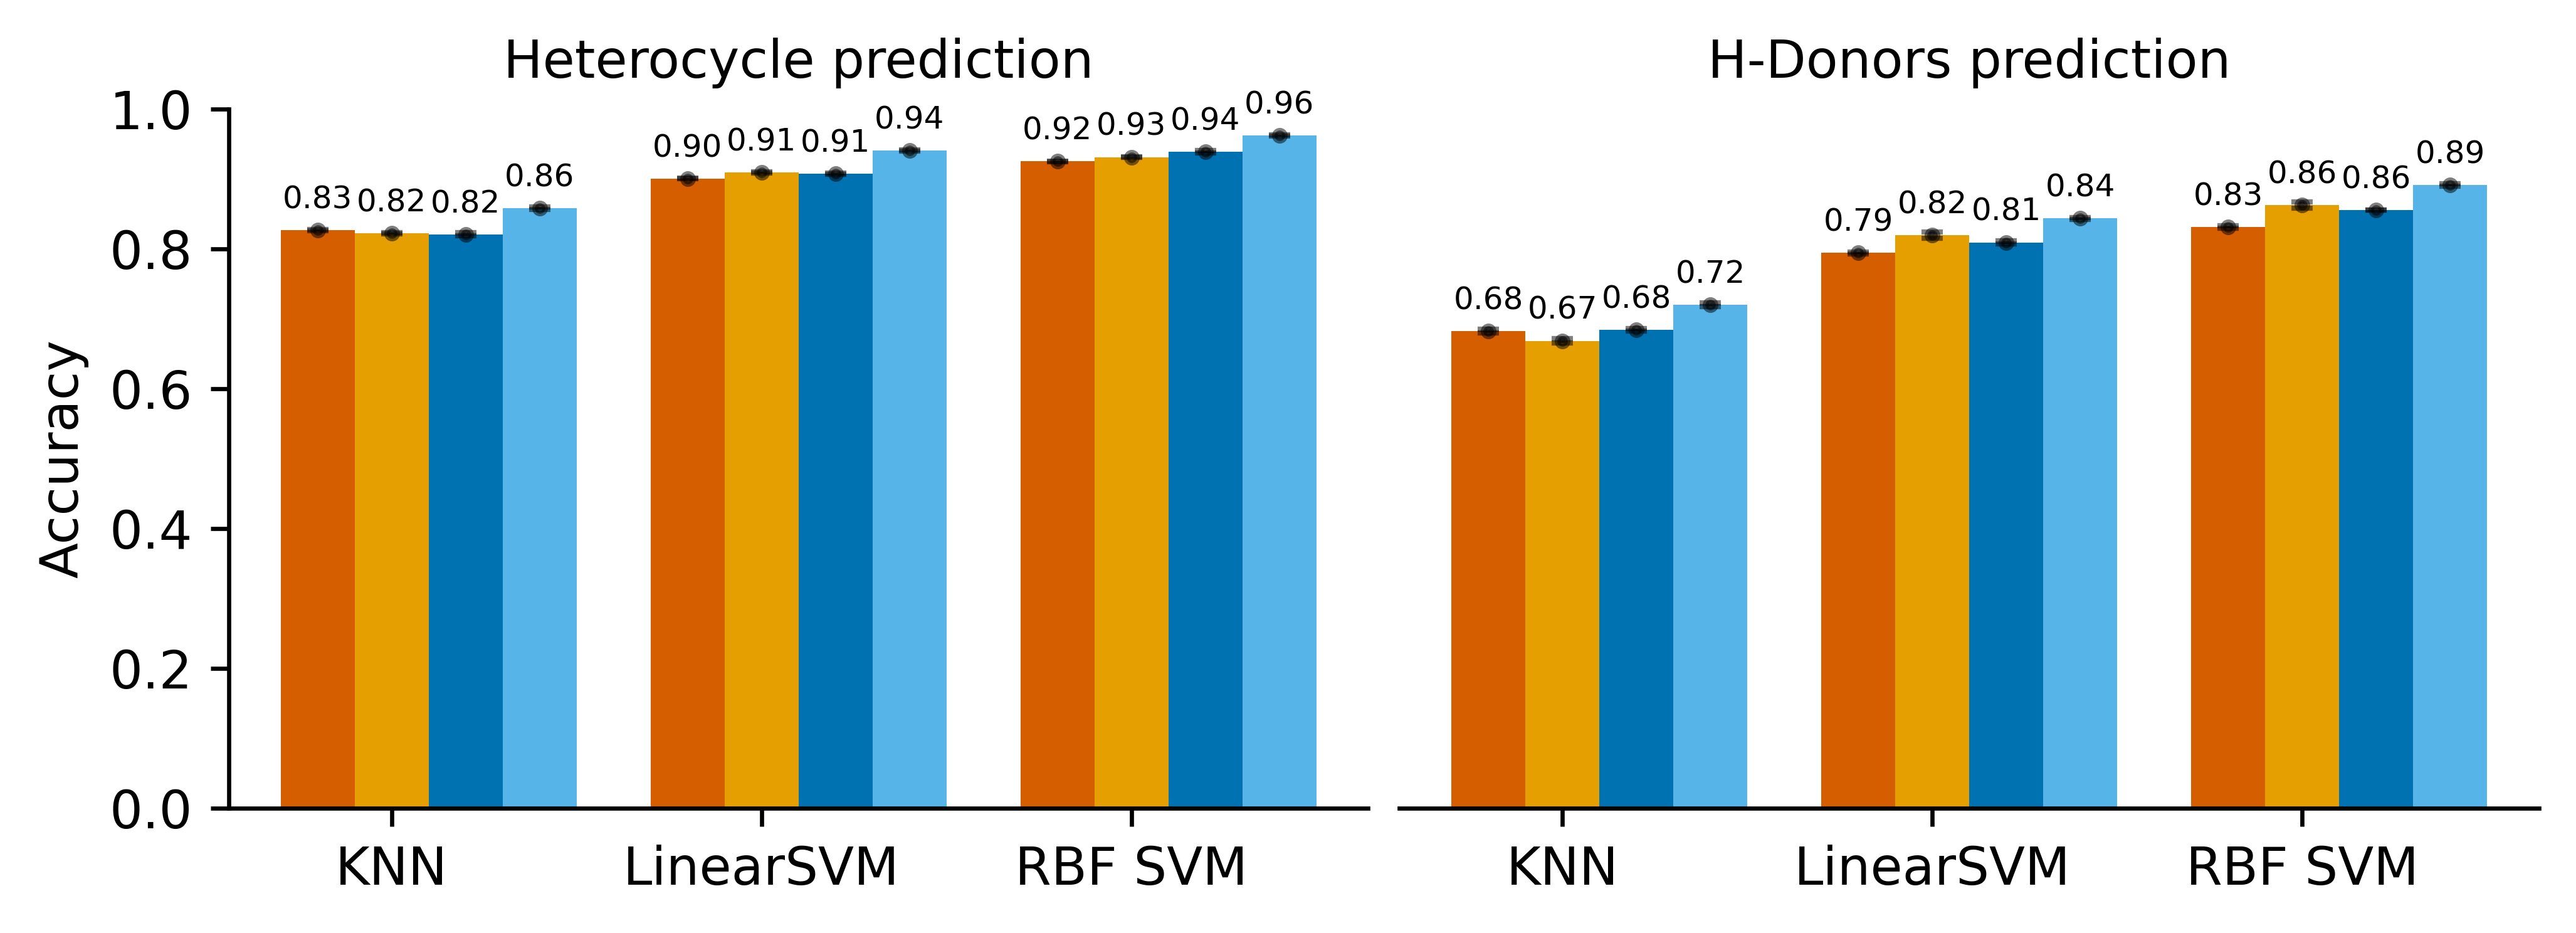

In [6]:
classifiers = ("KNN", "LinearSVM", "RBF SVM")
nice_rows = ["RoBERTa, SELFIES","RoBERTa, SMILES", "BART, SELFIES", "BART, SMILES",]
data_hetero = {nice_rows[it]: vals for it, vals in enumerate(full_pivot[full_pivot.index.isin(interesting_rows)]["best_scores"]["Heterocycles"].sort_values(by=["architecture",'embedding'], ascending=[False,True]).values)}
std_hetero = {nice_rows[it]: vals for it, vals in enumerate(full_pivot[full_pivot.index.isin(interesting_rows)]["std"]["Heterocycles"].sort_values(by=["architecture",'embedding'], ascending=[False,True]).values)}
data_hdonor = {nice_rows[it]: vals for it, vals in enumerate(full_pivot[full_pivot.index.isin(interesting_rows)]["best_scores"]["NumHDonors"].sort_values(by=["architecture",'embedding'], ascending=[False,True]).values)}
std_hdonor = {nice_rows[it]: vals for it, vals in enumerate(full_pivot[full_pivot.index.isin(interesting_rows)]["std"]["NumHDonors"].sort_values(by=["architecture",'embedding'], ascending=[False,True]).values)}

datas = [data_hetero, data_hdonor]
stds = [std_hetero, std_hdonor]
x = np.arange(len(classifiers))  # the label locations
width = 0.2  # the width of the bars

cm = 1/2.54  # centimeters in inches
plt.rcParams['font.size'] = 10
fig, axs = plt.subplots(ncols=2, figsize=(17.1*cm, 6*cm), dpi=600, layout='constrained')
plt.rcParams['font.size'] = 6
for it, ax in enumerate(axs):
    data = datas[it]
    std = stds[it]
    multiplier = 0
    ax.set_ylim(0,1)
    for attribute, measurement in data.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        print(std[attribute],)
        ax.errorbar(x + offset, measurement, std[attribute], fmt='.', color='Black', elinewidth=1,capthick=1,errorevery=1, alpha=0.5, ms=4, capsize = 2)
        ax.bar_label(rects, padding=3, fmt='%.2f')
        multiplier += 1
    if it == 0:
        ax.spines[['right', 'top', ]].set_visible(False)
        ax.set_ylabel('Accuracy')
        ax.set_title('Heterocycle prediction', fontsize=10)
    else:
        ax.spines[['right', 'top', "left"]].set_visible(False)
        ax.tick_params(left=[])
        ax.set_yticks([])
        ax.set_title('H-Donors prediction', fontsize=10)
    ax.set_xticks(x + width, classifiers)
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.05),ncol=4, fontsize=10)
plt.savefig(PLOT_PATH/'weak_classifiers_chatgpt.pdf', bbox_inches='tight',dpi=600, transparent=True)
plt.savefig(PLOT_PATH/'weak_classifiers_chatgpt.png', bbox_inches='tight',dpi=600, transparent=True)
plt.show()

## Plot regression

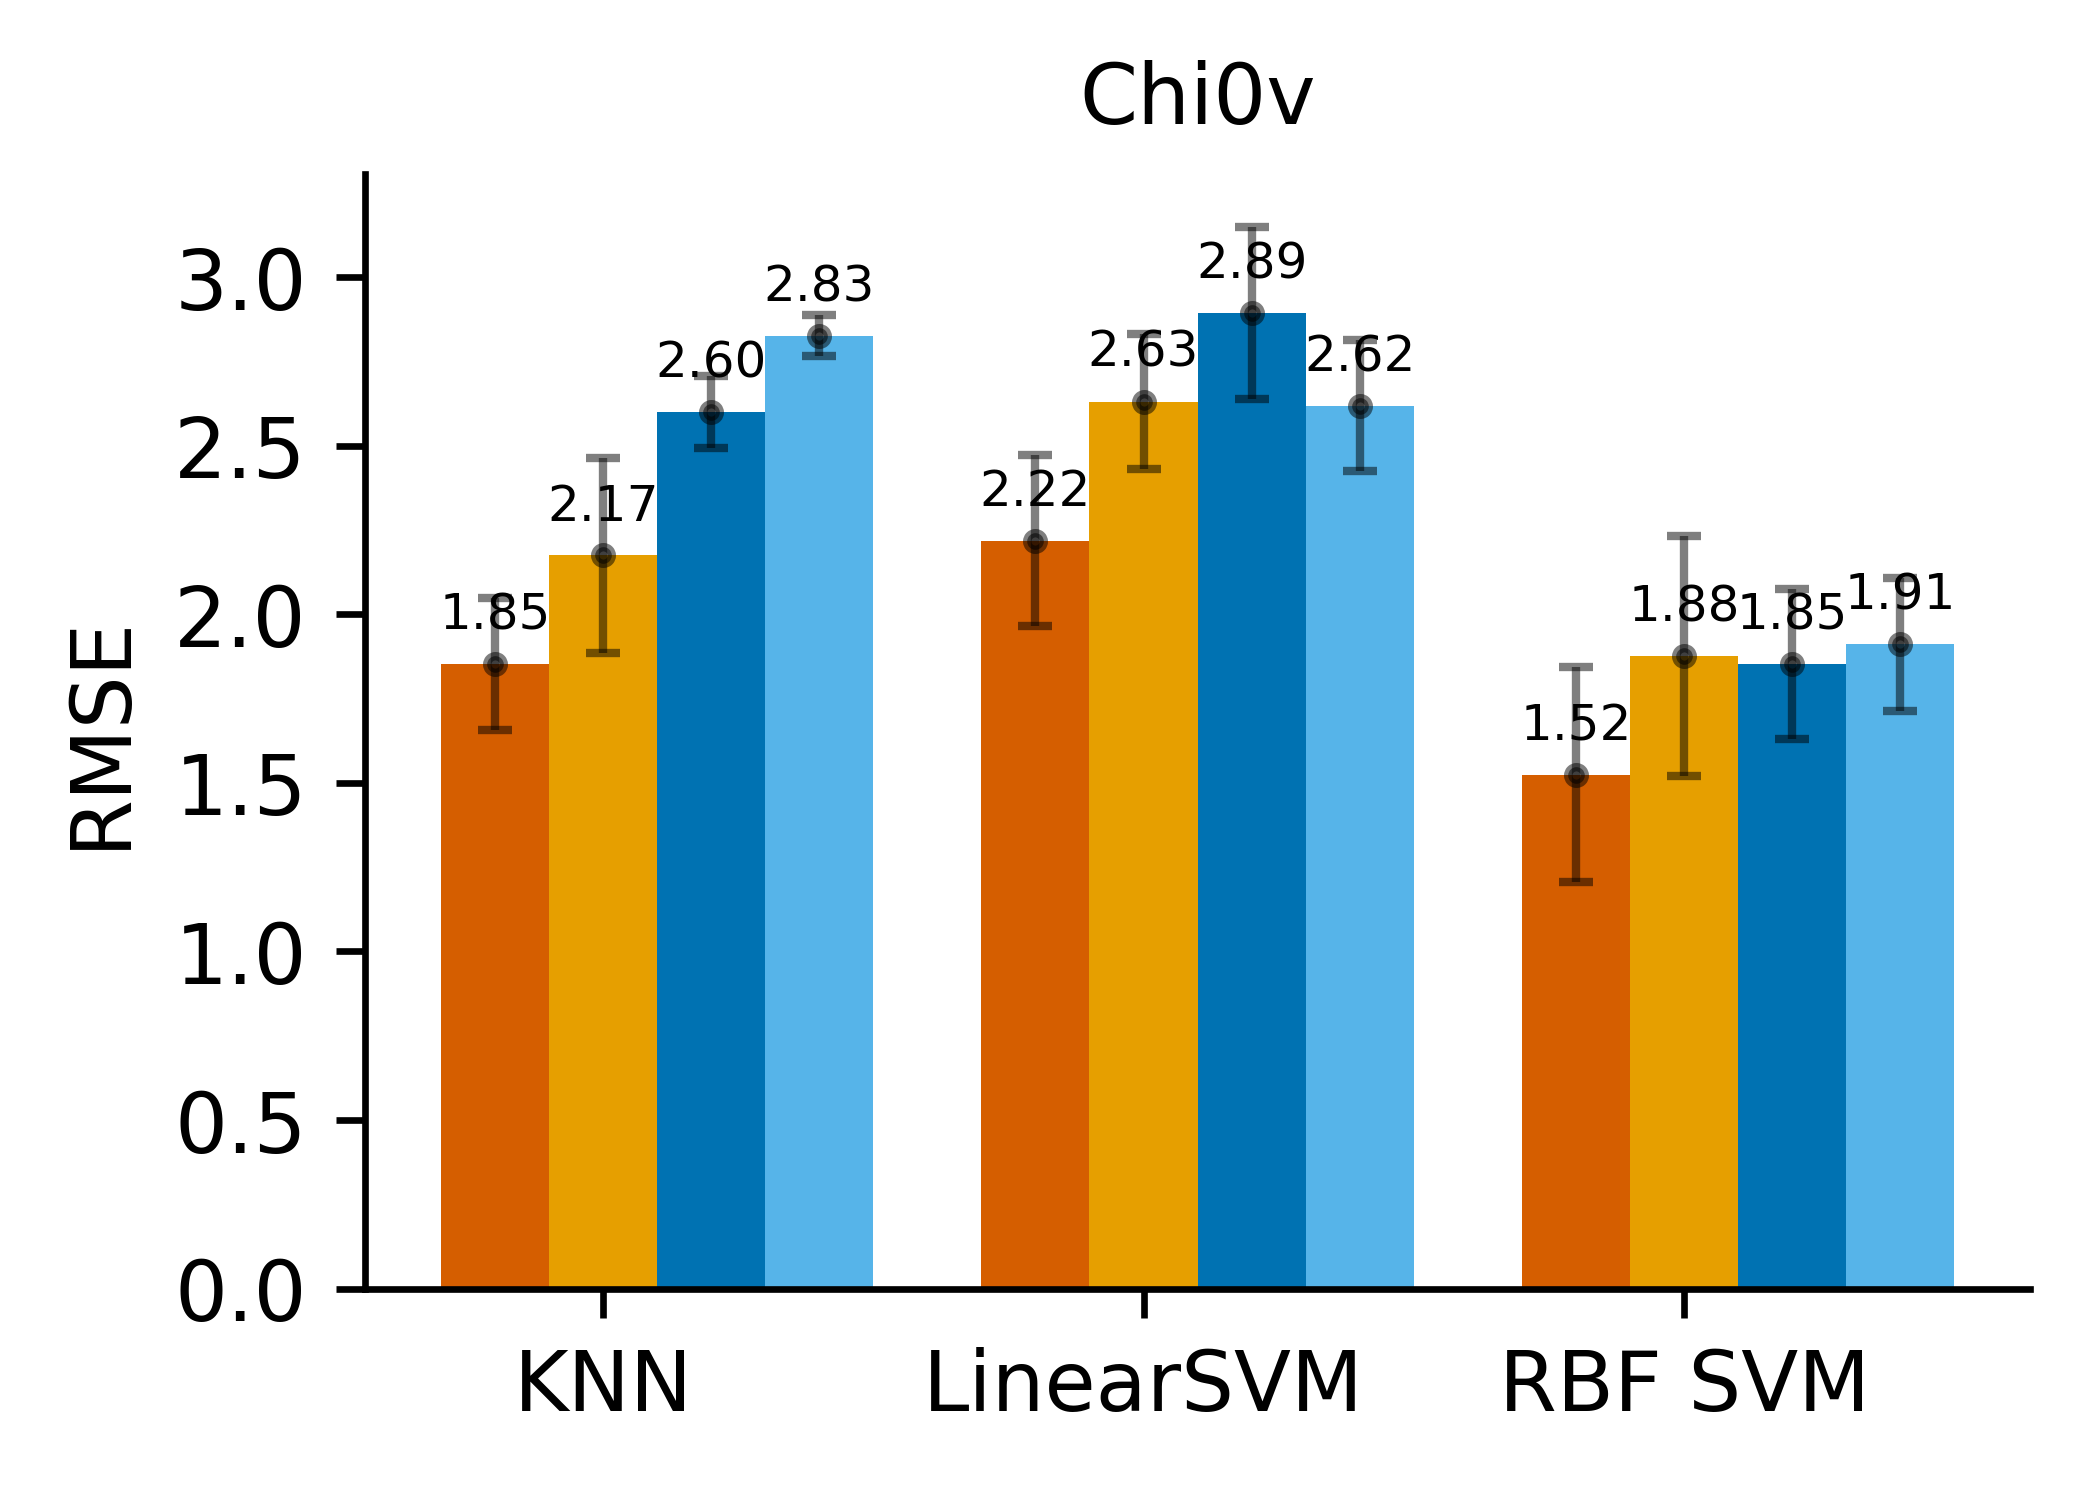

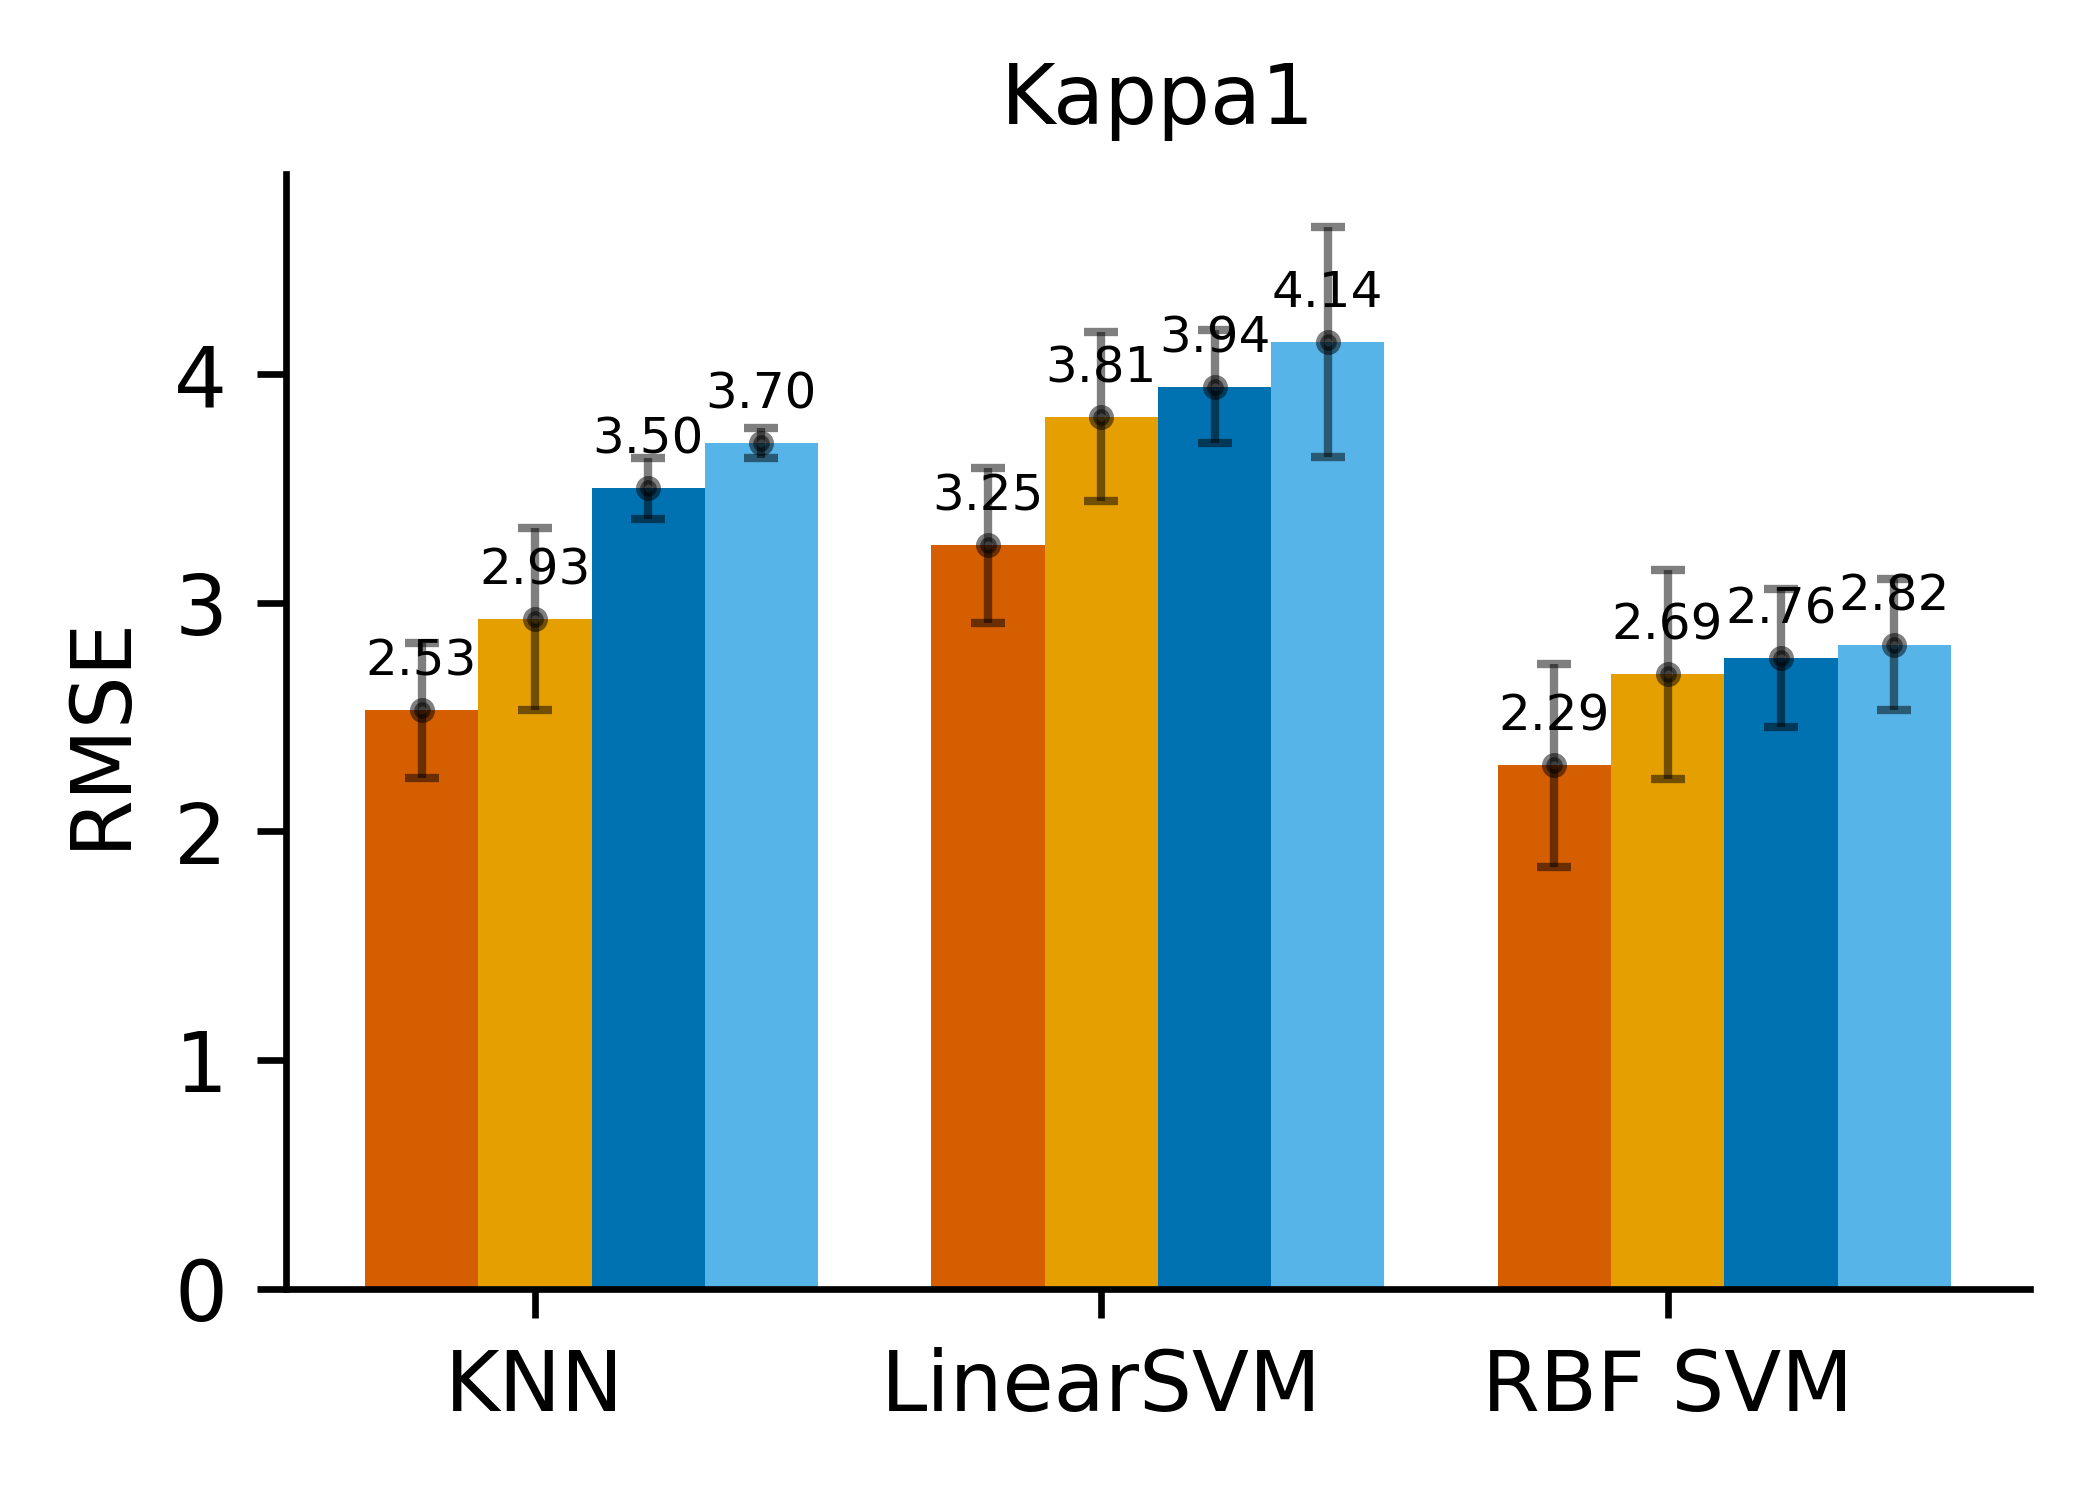

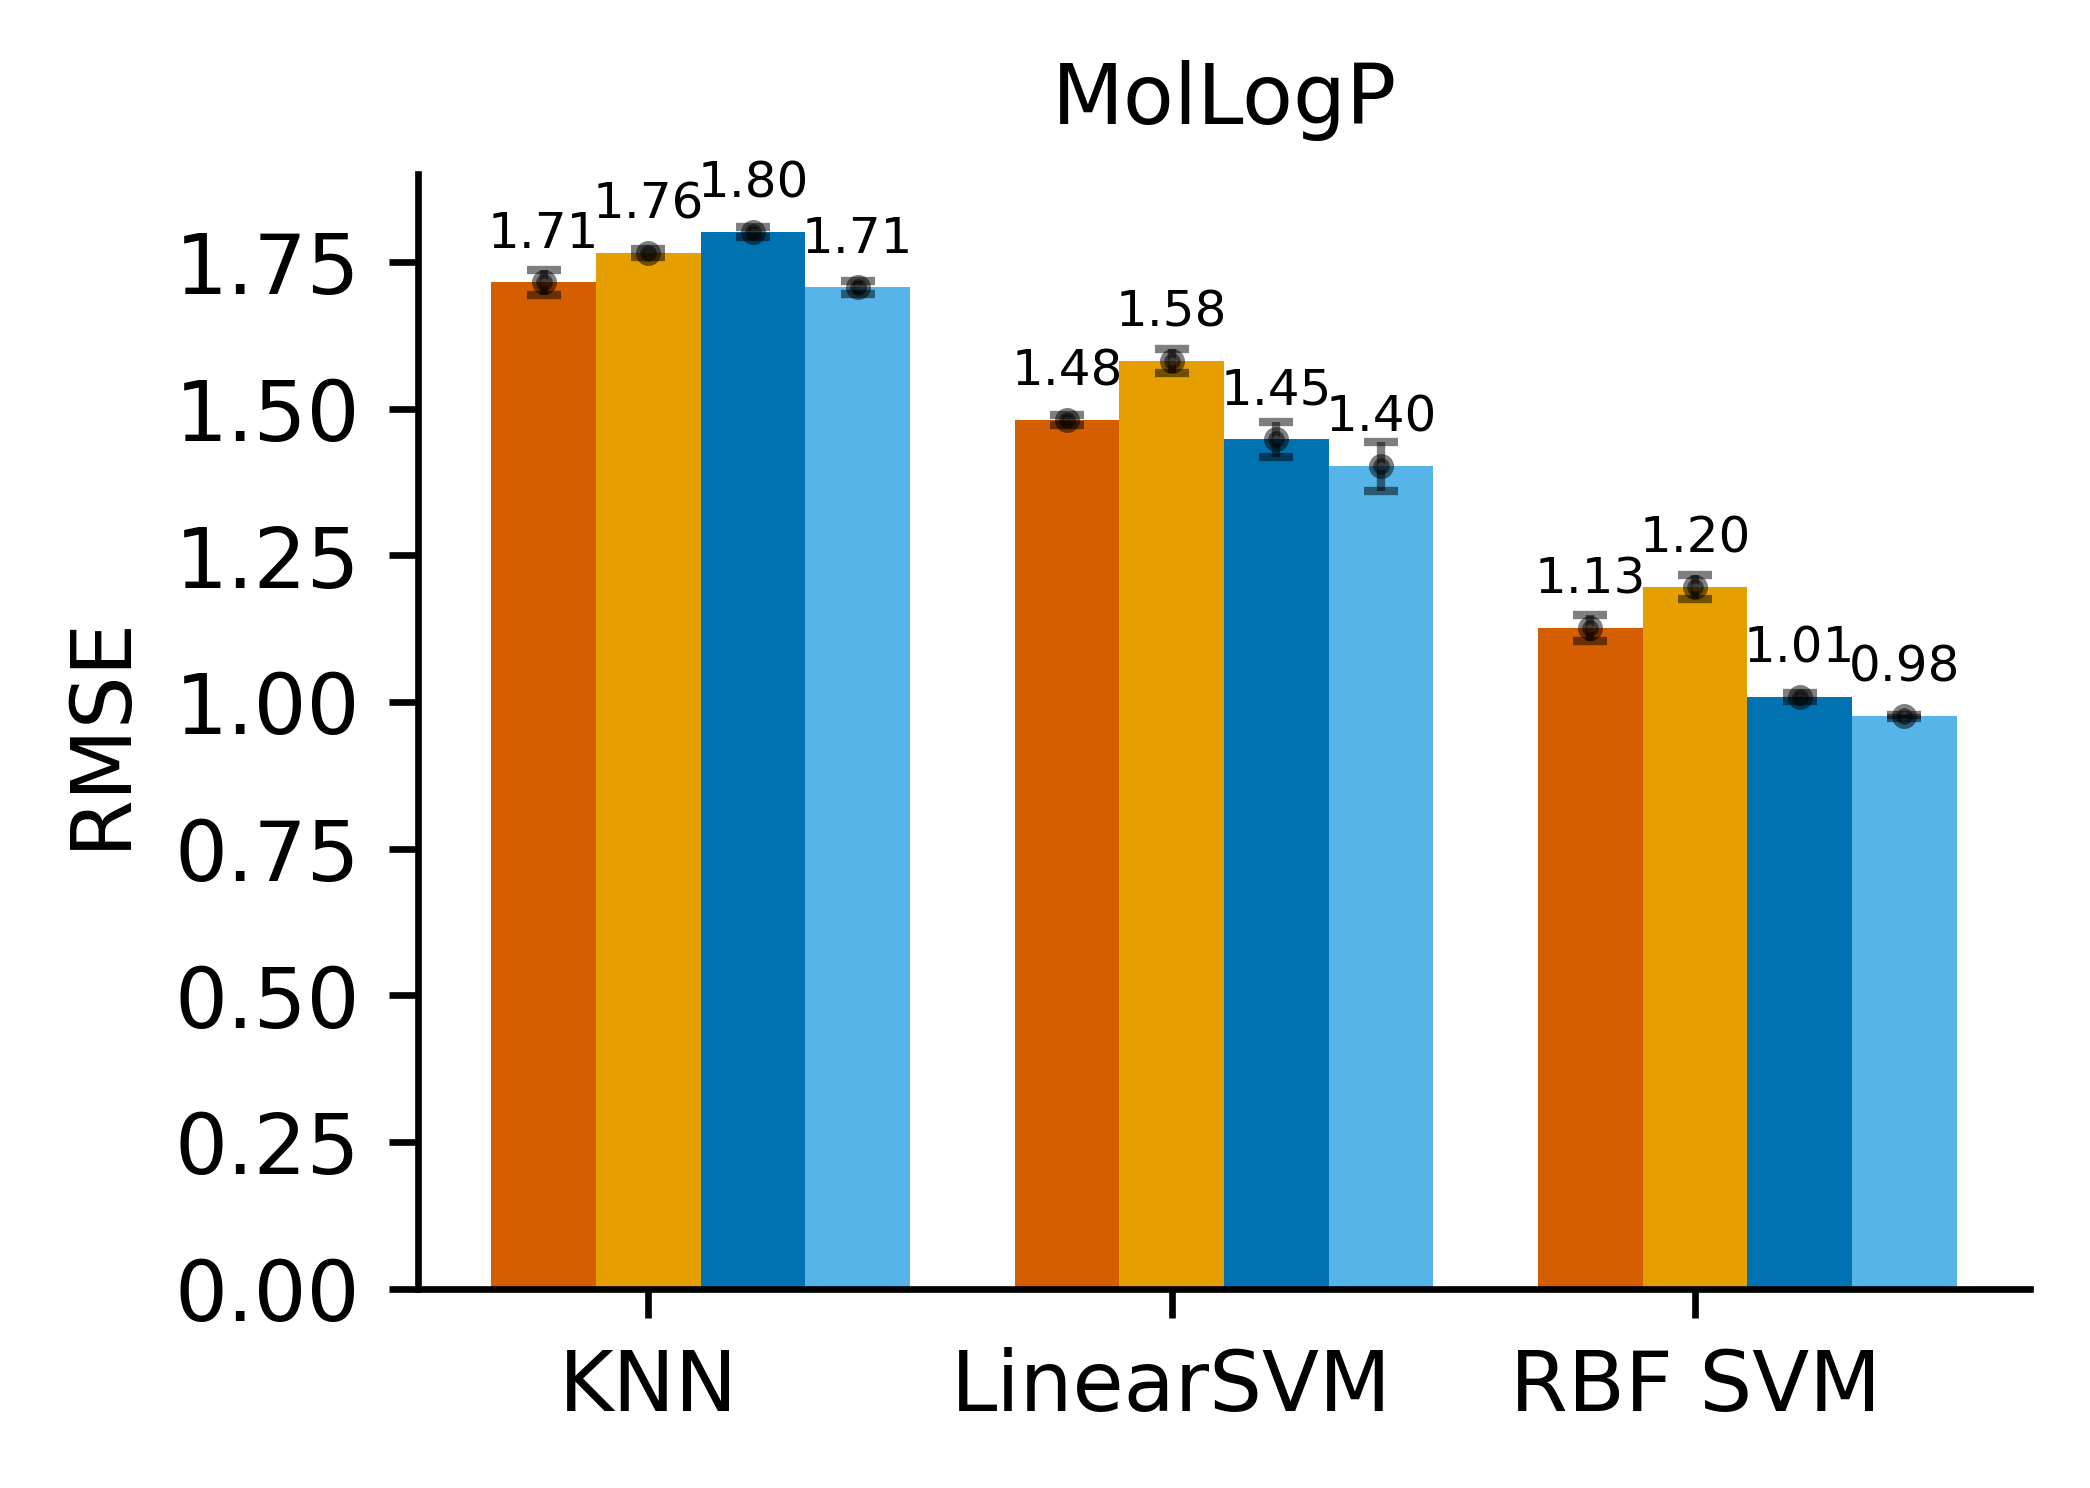

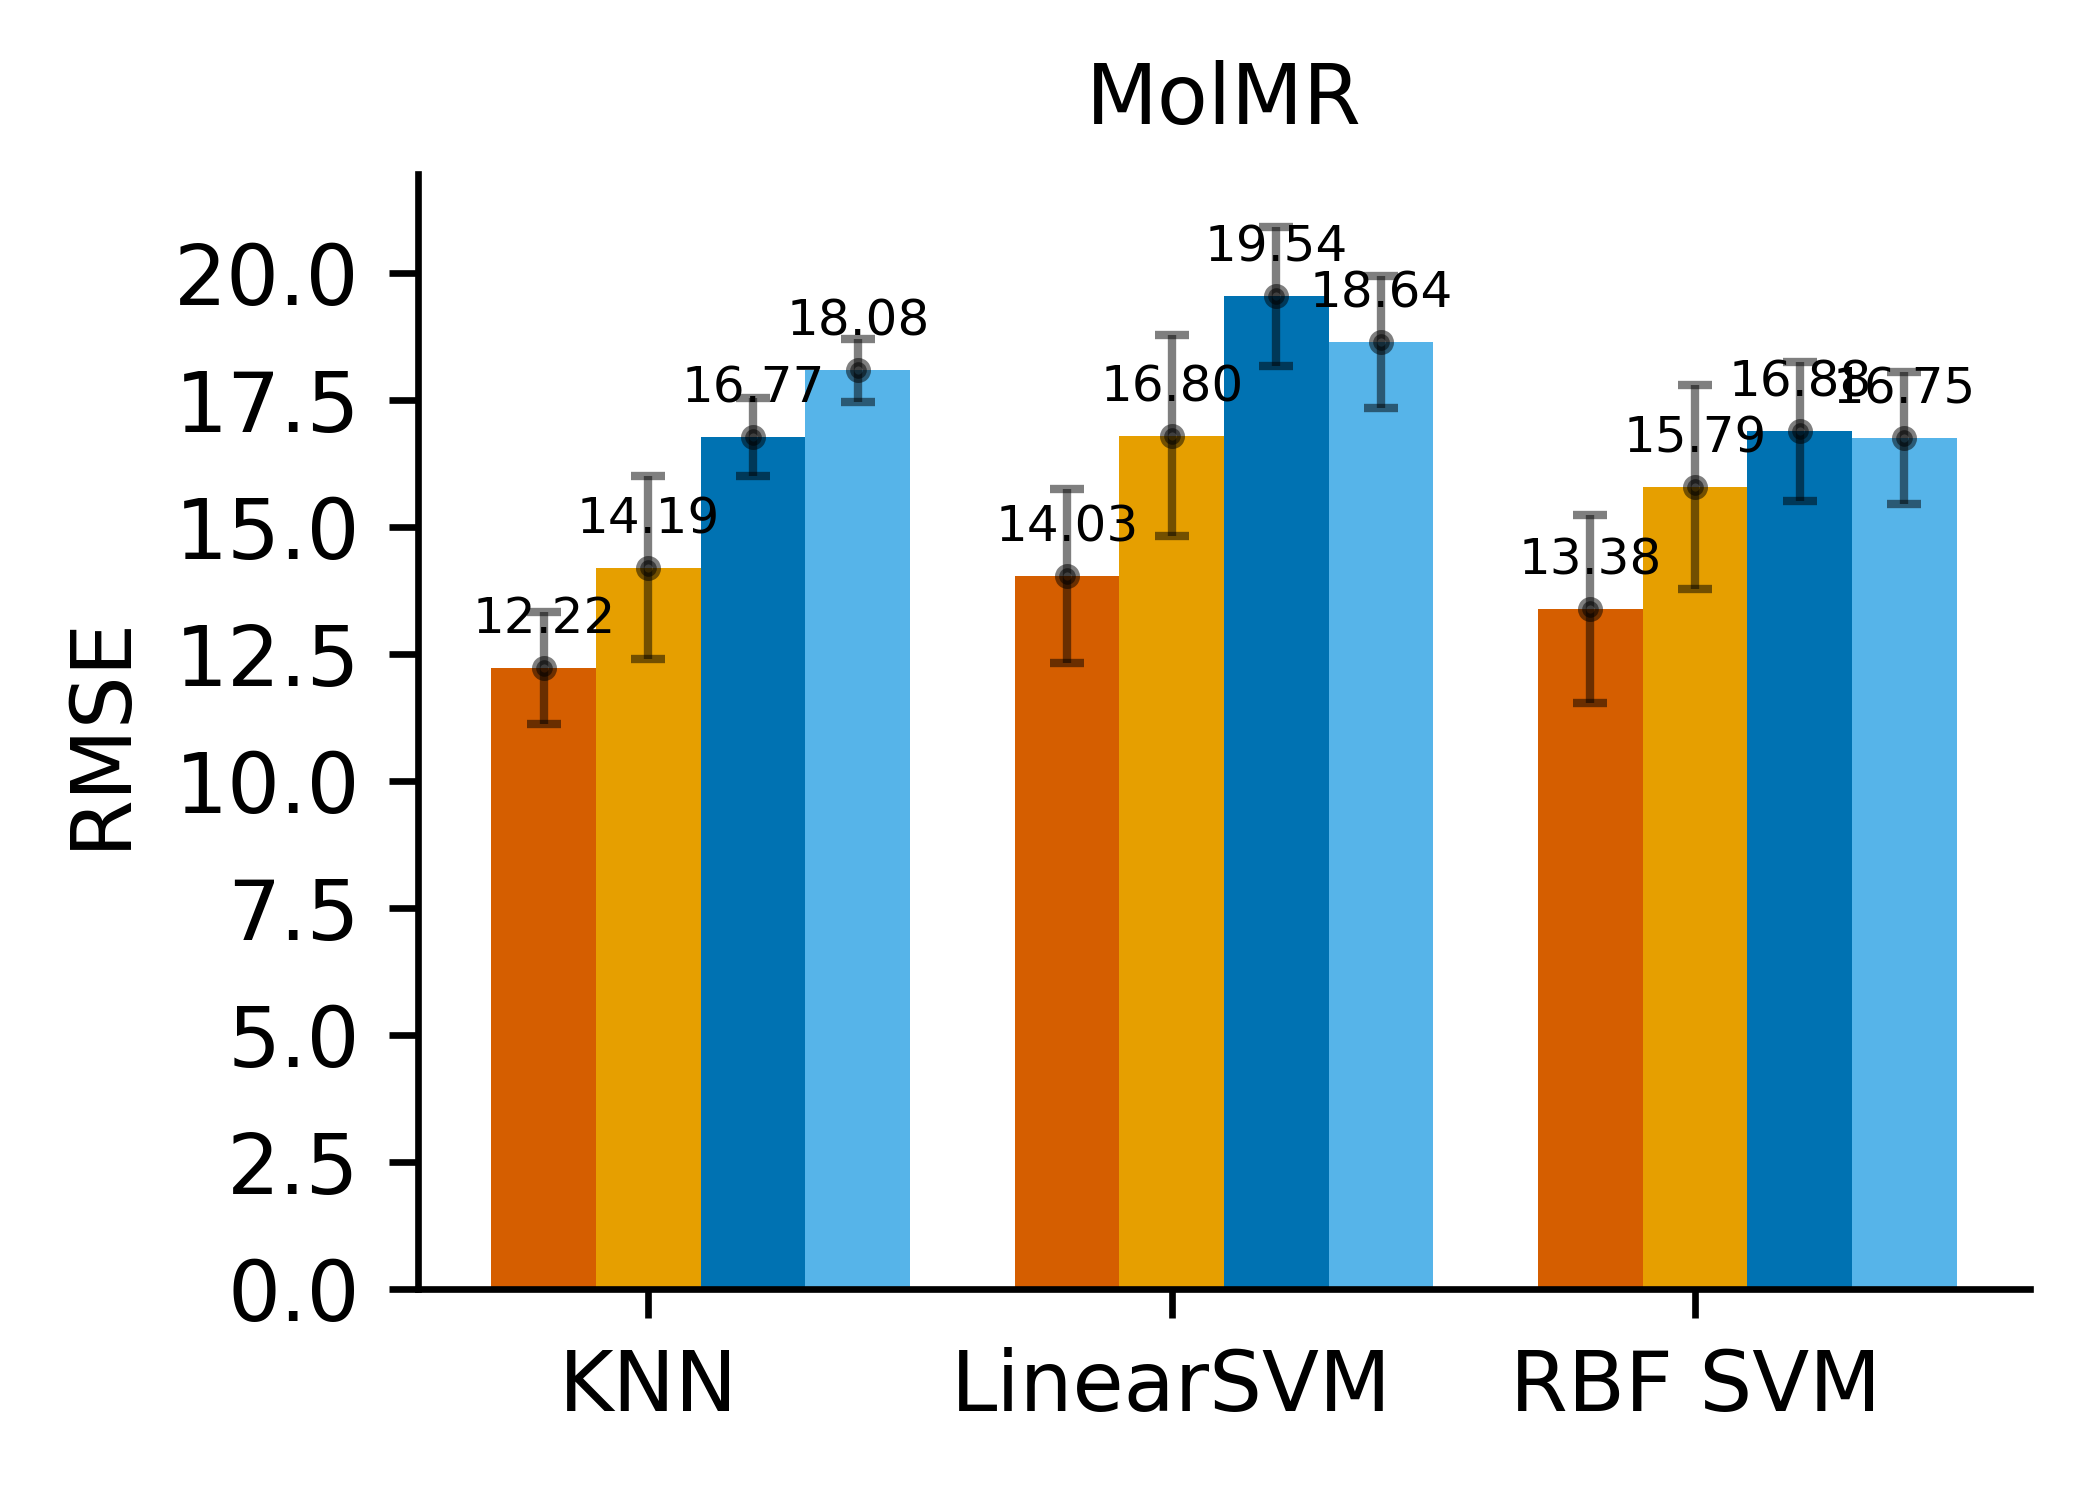

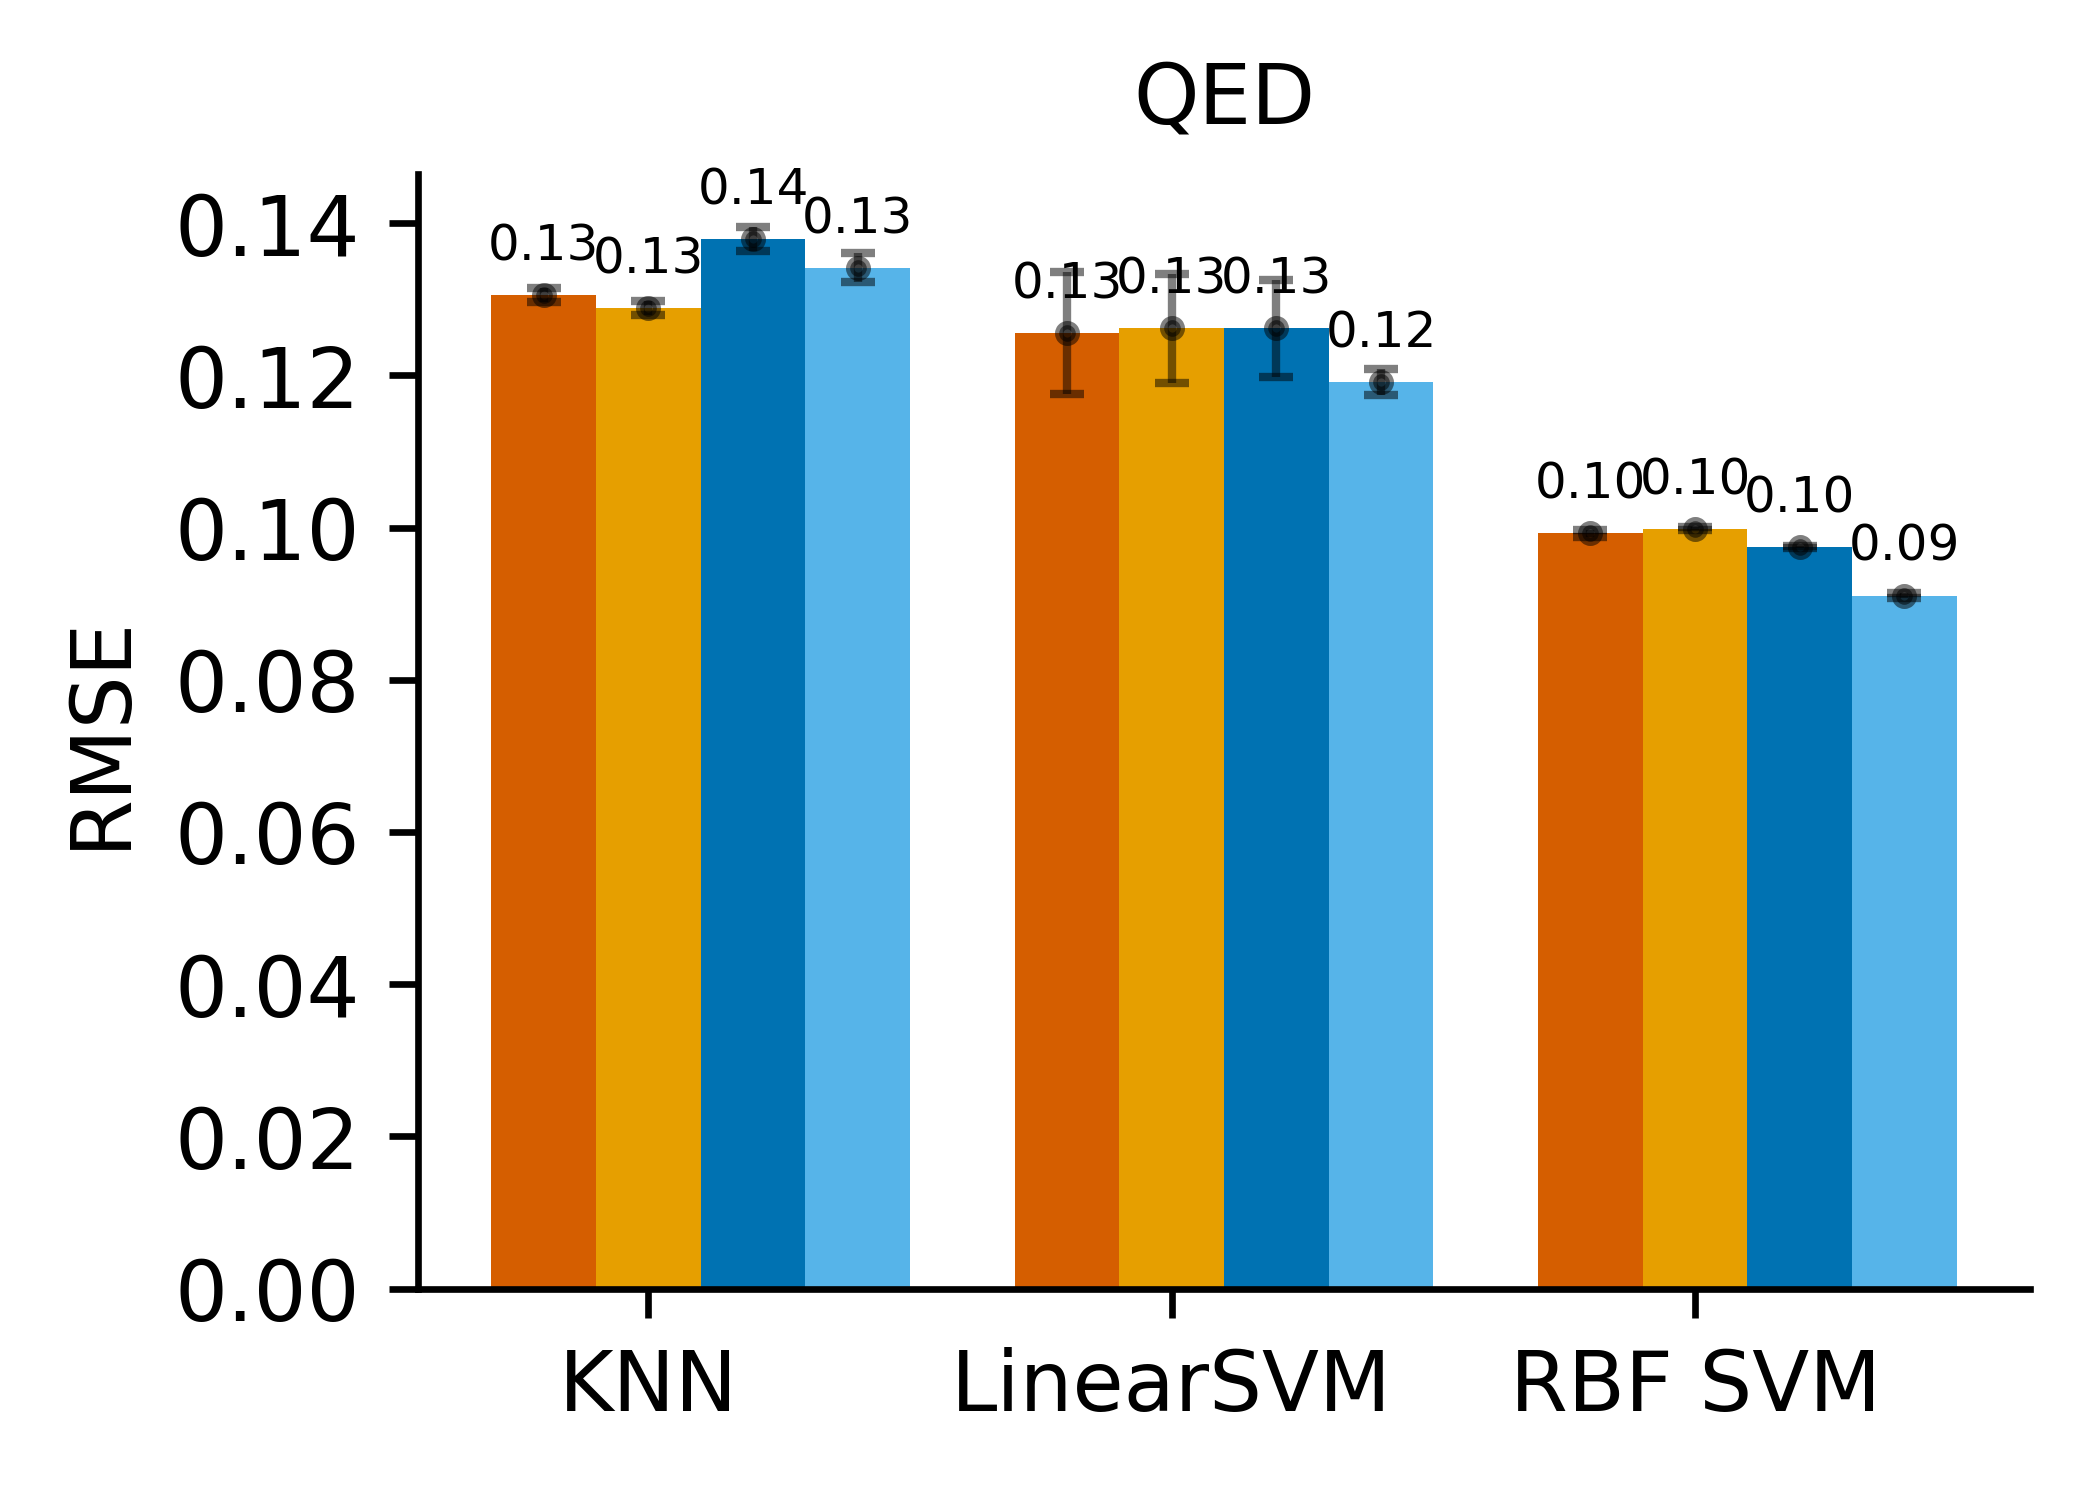

In [7]:
classifiers = ("KNN", "LinearSVM", "RBF SVM")
nice_rows = ["RoBERTa, SELFIES","RoBERTa, SMILES", "BART, SELFIES", "BART, SMILES",]
tasks = ["Chi0v","Kappa1", "MolLogP", "MolMR", "QED"]
data_dict = {}
std_dict = {}
for task in tasks:
    data_dict[task] = {nice_rows[it]: vals for it, vals in enumerate(full_pivot[full_pivot.index.isin(interesting_rows)]["best_scores"][task].sort_values(by=["architecture",'embedding'], ascending=[False,True]).values)}
    std_dict[task] = {nice_rows[it]: vals for it, vals in enumerate(full_pivot[full_pivot.index.isin(interesting_rows)]["std"][task].sort_values(by=["architecture",'embedding'], ascending=[False,True]).values)}
    
datas = [data_hetero, data_hdonor]
stds = [std_hetero, std_hdonor]
x = np.arange(len(classifiers))  # the label locations
width = 0.2  # the width of the bars

cm = 1/2.54  # centimeters in inches
for task in tasks:
    plt.rcParams['font.size'] = 10
    fig, axs = plt.subplots(ncols=1, figsize=(17.1*cm/2, 6*cm), dpi=600, layout='constrained')
    ax = plt.gca()
    plt.rcParams['font.size'] = 6
    data = data_dict[task]
    std = std_dict[task]
    multiplier = 0
    for attribute, measurement in data.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.errorbar(x + offset, measurement, std[attribute], fmt='.', color='Black', elinewidth=1,capthick=1,errorevery=1, alpha=0.5, ms=4, capsize = 2)
        ax.bar_label(rects, padding=3, fmt='%.2f')
        multiplier += 1
    ax.spines[['right', 'top', ]].set_visible(False)
    ax.set_ylabel('RMSE')
    ax.set_title(task, fontsize=10)
    ax.set_xticks(x + width, classifiers)     
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    #fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.05),ncol=4, fontsize=10)
    plt.savefig(PLOT_PATH/f'other_weak_classifiers_{task}.pdf', bbox_inches='tight',dpi=600, transparent=True)
    plt.savefig(PLOT_PATH/f'other_weak_classifiers_{task}.png', bbox_inches='tight',dpi=600, transparent=True)
    plt.show()